# TP1 - 22.45 Redes Neuronales - Regresión Logística y Lineal

## Regresión Lineal

### Import required libraries and dataset

In [168]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
import datetime
from os.path import exists
tf.config.set_visible_devices([], 'GPU')

### Download and load the MNIST dataset and morphometrics extensions

In [169]:
(x_train, y_train) , (x_test, y_test) = mnist.load_data()
train_morpho = pd.read_csv("train-morpho.csv")
test_morpho = pd.read_csv("t10k-morpho.csv")

### Normalize the dataset

In [170]:
data_max = np.max(x_train)
print(data_max)
x_train = x_train.astype('float32') / data_max
x_test = x_test.astype('float32') / data_max

255


### Separate attributes per digit

In [171]:
digit_values = []
for i in range(10):
    digit_values.append(train_morpho[y_train == i])

### Exploratory Data Analysis

#### Example: Show the first object of the train dataset

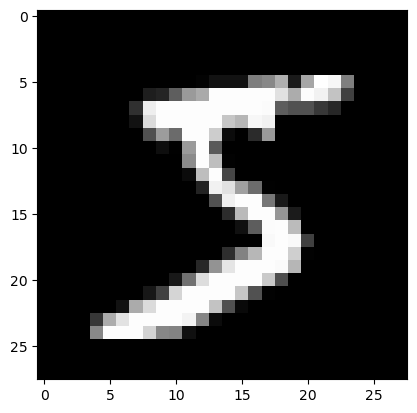

In [172]:
plt.imshow(x_train[0,...], cmap="gray")

#### Show a few instances of each class

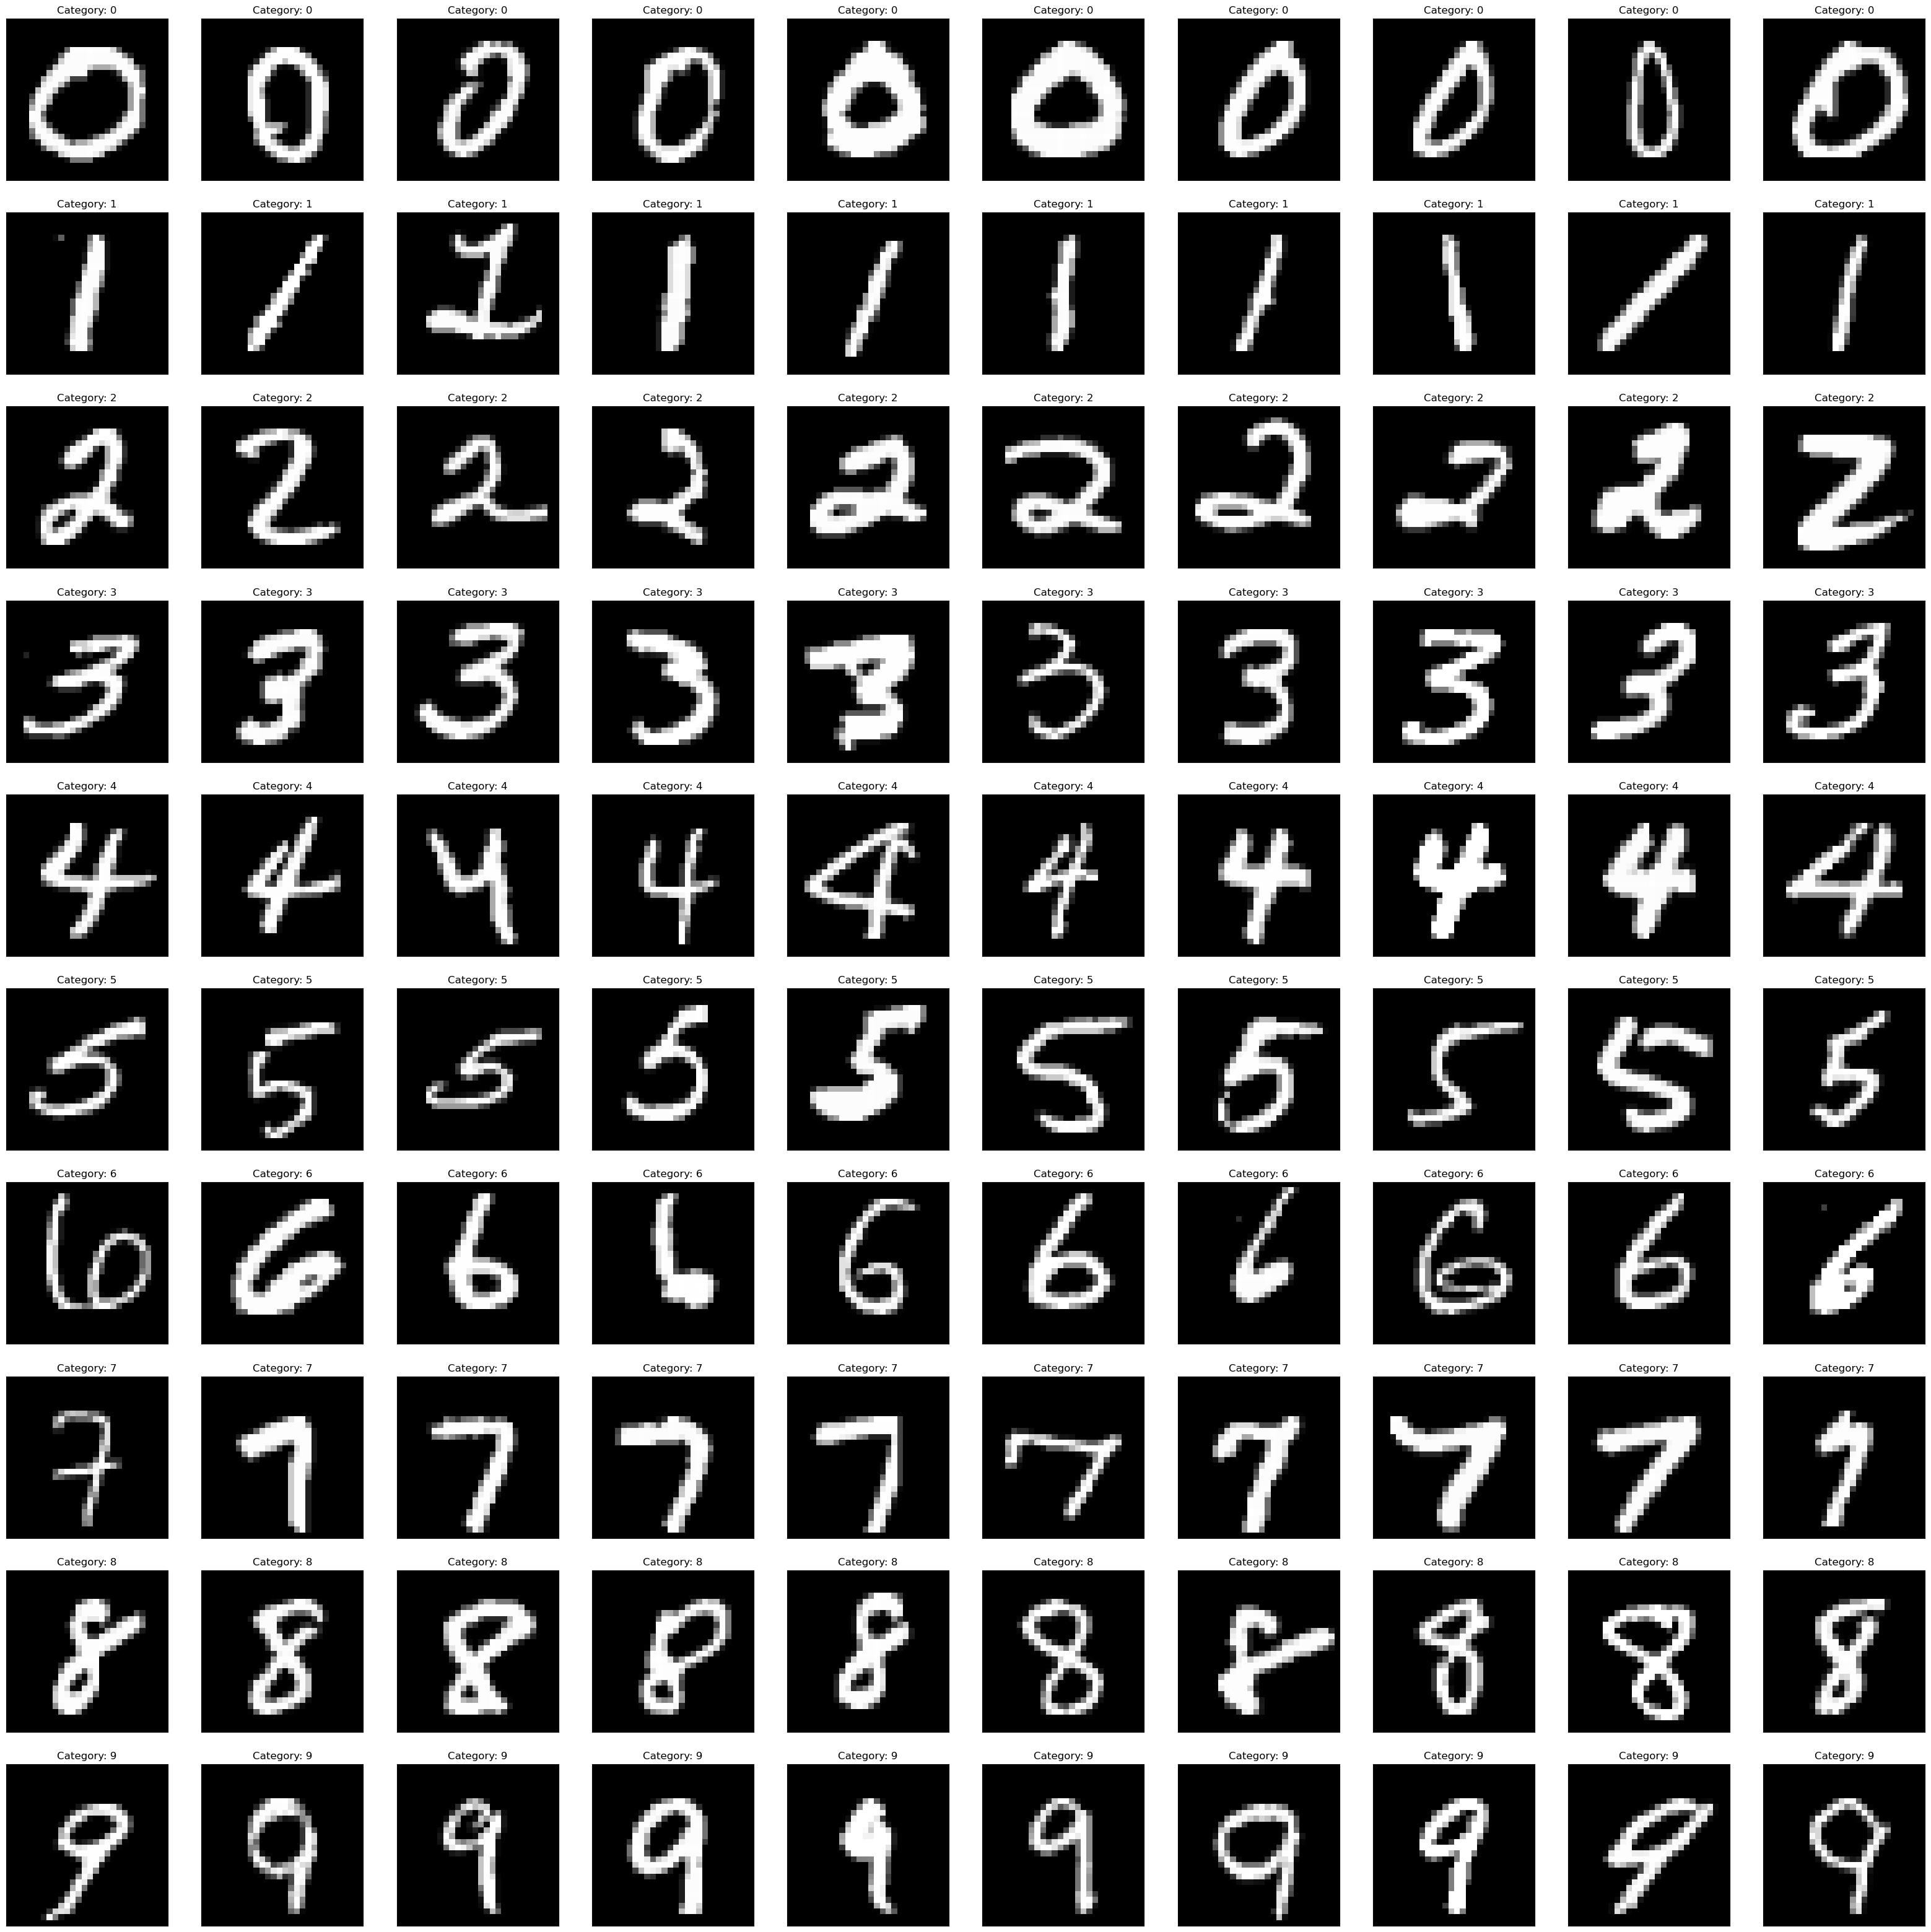

In [173]:
fig = plt.figure(figsize=(40, 40))  # width, height in inches

# idx works on np.array and not lists.
idx = np.argsort(y_train)

train_X_sorted = np.array(x_train)[idx]
train_y_sorted = np.array(y_train)[idx]

count = 0

for i in range(100):
    count = int(np.floor(i / 10))
    sub = fig.add_subplot(10, 10, i + 1, xticks=[], yticks=[])
    sub.imshow(train_X_sorted[np.where(train_y_sorted == count)[0][i - count * 10],:,:], interpolation='nearest', cmap='gray')
    sub.set_title('Category: ' + str(count))

#### Look at the data distribution

##### Training data

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
[5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]


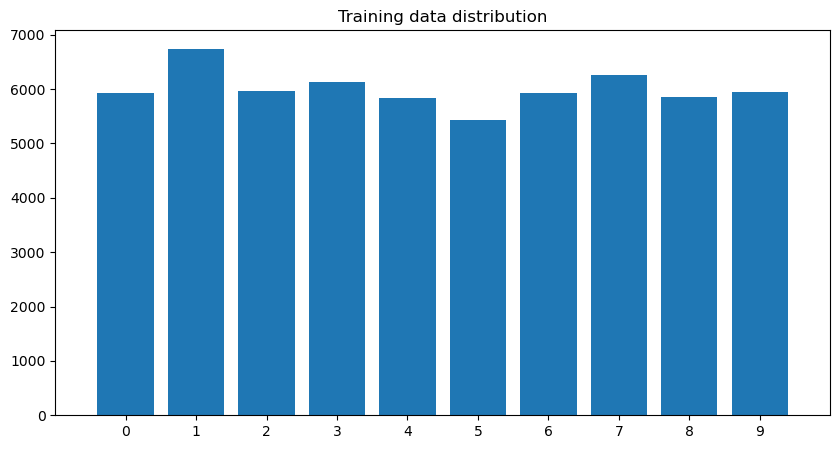

In [174]:
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))

counts = np.bincount(y_train)
print(counts)

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(range(10), counts, width=0.8, align='center')
ax.set(xticks=range(10), xlim=[-1, 10], title='Training data distribution')

plt.show()

##### Testing data

{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}
[ 980 1135 1032 1010  982  892  958 1028  974 1009]


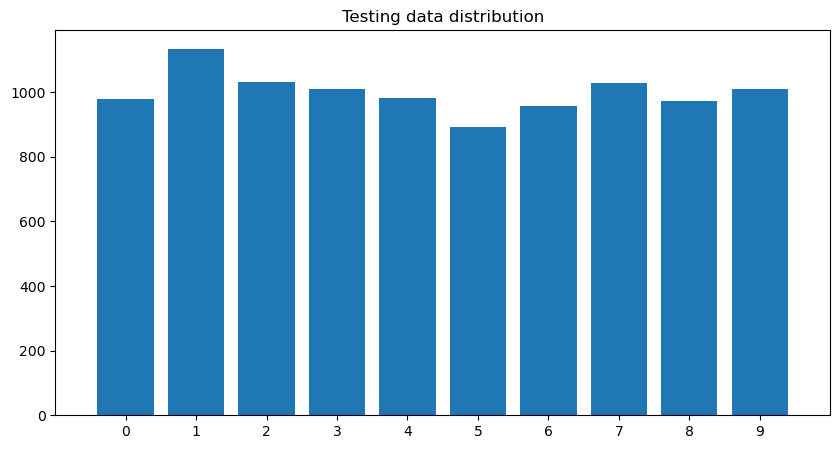

In [175]:
unique, counts = np.unique(y_test, return_counts=True)
print(dict(zip(unique, counts)))

counts = np.bincount(y_test)
print(counts)

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(range(10), counts, width=0.8, align='center')
ax.set(xticks=range(10), xlim=[-1, 10], title='Testing data distribution')

plt.show()

#### Slant Histograms

##### Training data

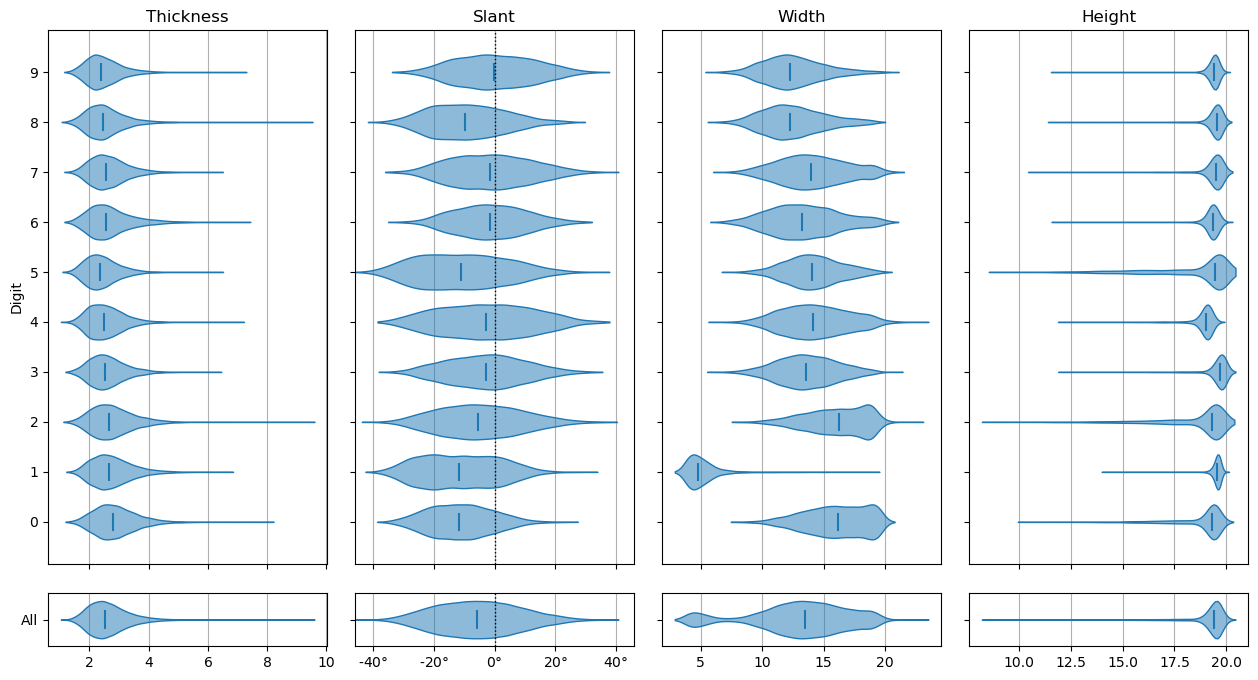

In [176]:
train_morpho['digit'] = y_train
train_morpho['slant_deg'] = np.rad2deg(np.arctan(-train_morpho['slant']))


cols = ['thickness', 'slant_deg', 'width', 'height']
labels = ['Thickness', 'Slant', 'Width', 'Height']
fig, axs = plt.subplots(2, len(cols), sharex='col', sharey='row', figsize=(12, 8),
                            gridspec_kw=dict(height_ratios=[10, 1], hspace=.1, wspace=.1, left=0,
                                             right=1))

def format_violinplot(parts):
    for pc in parts['bodies']:
        pc.set_facecolor('#1f77b480')
        pc.set_edgecolor('C0')
        pc.set_alpha(None)

for c, col in enumerate(cols):
    ax = axs[0, c]
    parts = ax.violinplot([train_morpho.loc[train_morpho['digit'] == d, col] for d in range(10)],
                              positions=np.arange(10), vert=False, widths=.7,
                              showextrema=False, showmedians=True)
    format_violinplot(parts)
    format_violinplot(axs[1, c].violinplot(train_morpho[col], vert=False, widths=.7,
                                               showextrema=False, showmedians=True))
    ax.set_title(labels[c])
    ax.set_axisbelow(True)
    ax.grid(axis='x')
    axs[1, c].set_axisbelow(True)
    axs[1, c].grid(axis='x')

axs[0, 0].yaxis.set_major_locator(ticker.MultipleLocator(1))
axs[0, 0].set_ylabel("Digit")

axs[1, 0].set_yticks([1])
axs[1, 0].set_yticklabels(["All"])
axs[1, 0].set_ylim(.5, 1.5)
for ax in axs[:, 1]:
    ax.axvline(0., lw=1., ls=':', c='k')

axs[1, 1].set_xlim(-46, 46)
axs[1, 1].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}$\degree$"))
plt.show()

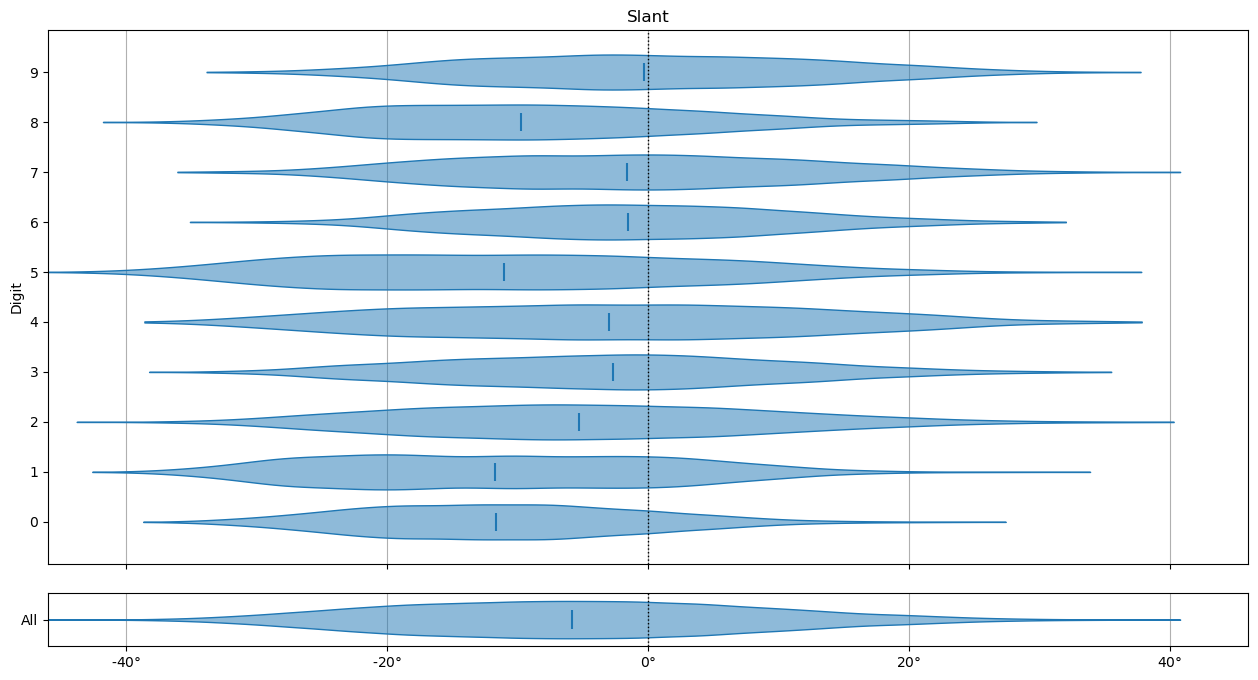

In [177]:
train_morpho['digit'] = y_train
train_morpho['slant_deg'] = np.rad2deg(np.arctan(-train_morpho['slant']))


cols = ['slant_deg']
labels = ['Slant']
fig, axs = plt.subplots(2, len(cols), sharex='col', sharey='row', figsize=(12, 8),
                            gridspec_kw=dict(height_ratios=[10, 1], hspace=.1, wspace=.1, left=0,
                                             right=1))

def format_violinplot(parts):
    for pc in parts['bodies']:
        pc.set_facecolor('#1f77b480')
        pc.set_edgecolor('C0')
        pc.set_alpha(None)

for c, col in enumerate(cols):
    ax = axs[0]
    parts = ax.violinplot([train_morpho.loc[train_morpho['digit'] == d, col] for d in range(10)],
                              positions=np.arange(10), vert=False, widths=.7,
                              showextrema=False, showmedians=True)
    format_violinplot(parts)
    format_violinplot(axs[1].violinplot(train_morpho[col], vert=False, widths=.7,
                                               showextrema=False, showmedians=True))
    ax.set_title(labels[c])
    ax.set_axisbelow(True)
    ax.grid(axis='x')
    axs[1].set_axisbelow(True)
    axs[1].grid(axis='x')

axs[0].yaxis.set_major_locator(ticker.MultipleLocator(1))
axs[0].set_ylabel("Digit")

axs[1].set_yticks([1])
axs[1].set_yticklabels(["All"])
axs[1].set_ylim(.5, 1.5)
for ax in axs[:]:
    ax.axvline(0., lw=1., ls=':', c='k')

axs[1].set_xlim(-46, 46)
axs[1].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}$\degree$"))
plt.show()

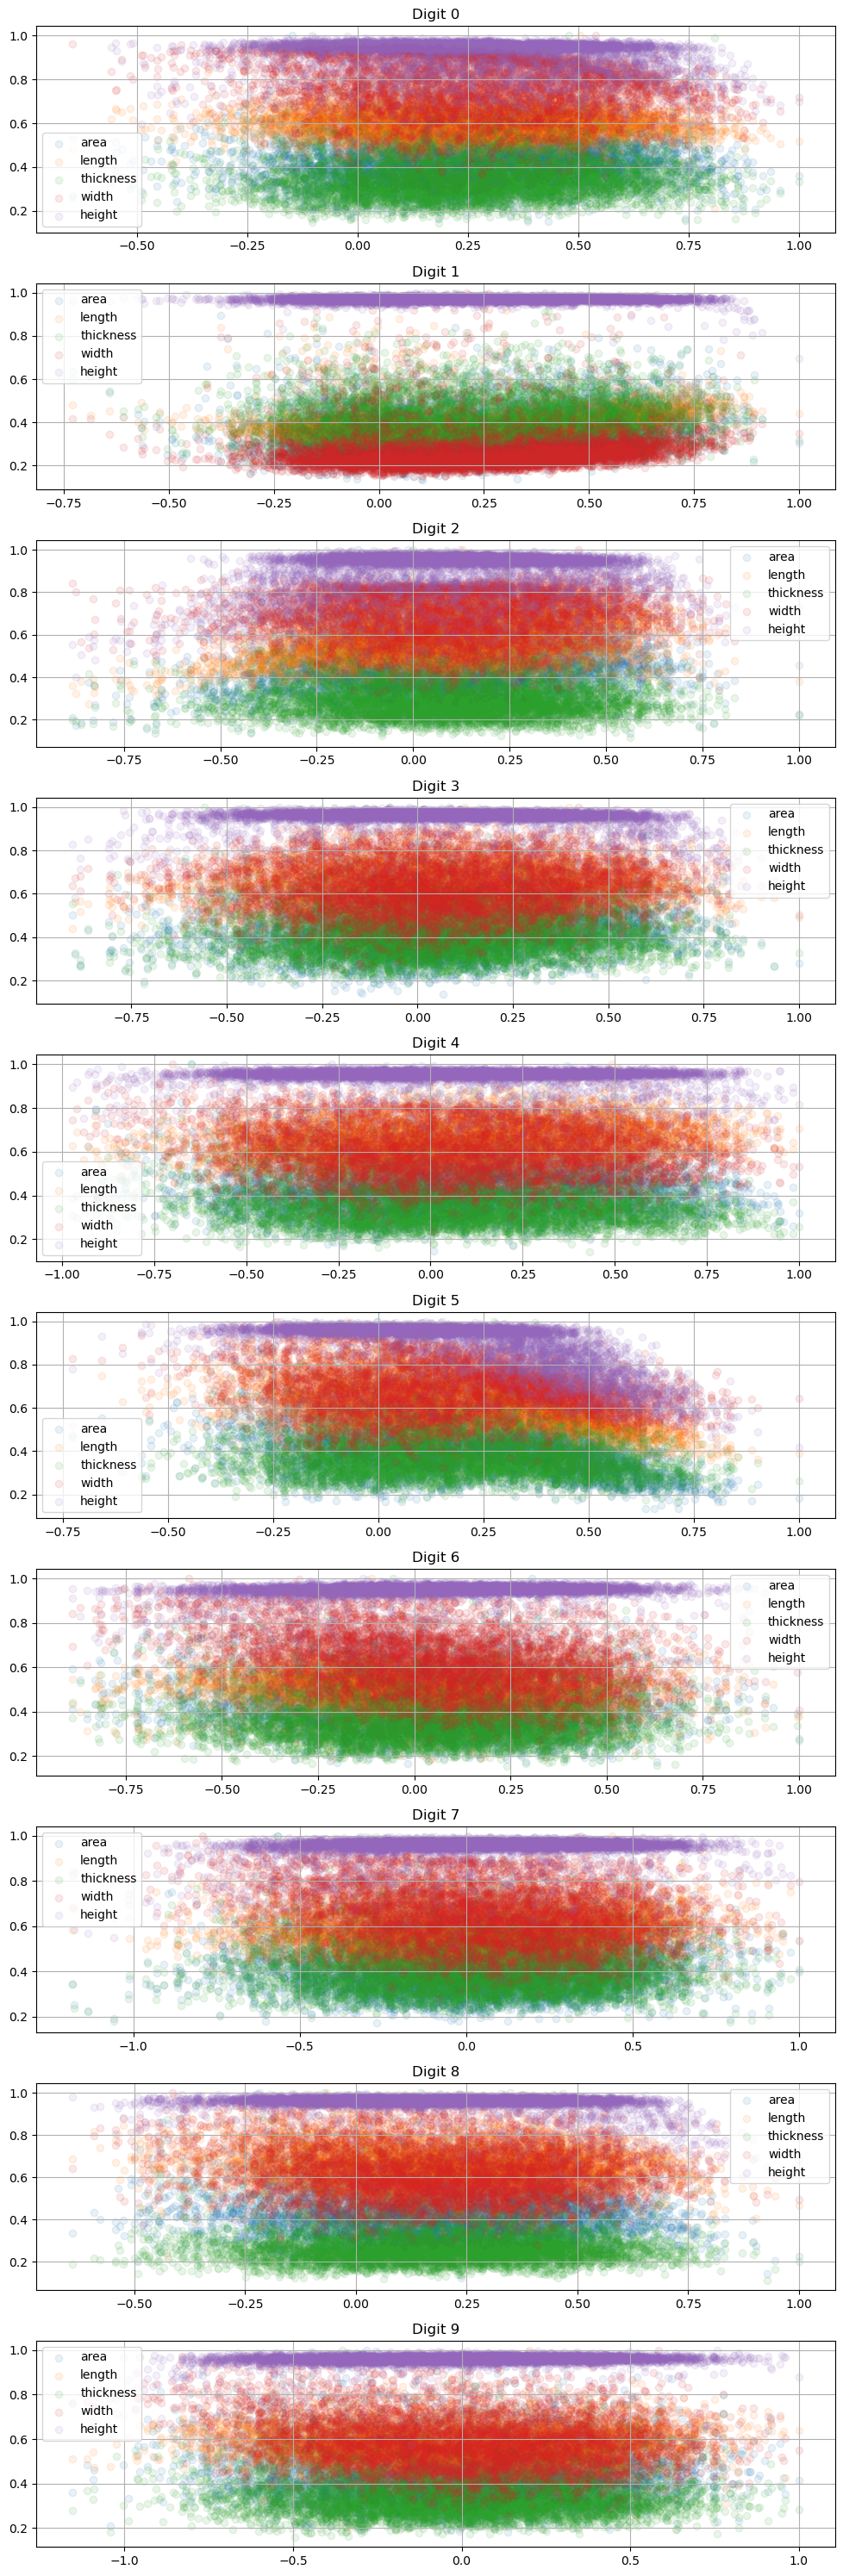

In [178]:
non_slant_labels = ['area', 'length', 'thickness', 'width', 'height']

plt.figure(figsize=(10,30))
for i in range(1, 11):
    plt.subplot(10, 1, i)
    plt.tight_layout()
    for k in range(len(non_slant_labels)):
        a = plt.scatter(x = digit_values[i - 1]['slant'].values / np.max(digit_values[i - 1]['slant'].values), # En X ponemos el valor normalizado de slant
                        y = digit_values[i - 1][non_slant_labels[k]].values / np.max(digit_values[i - 1][non_slant_labels[k]].values), # Y en Y el valor normalizado de los otros descriptores morfológicos
                        label = non_slant_labels[k],
                        alpha = 0.1)
    plt.title("Digit " + str(i - 1))
    plt.grid(True)
    plt.legend()

##### Testing data

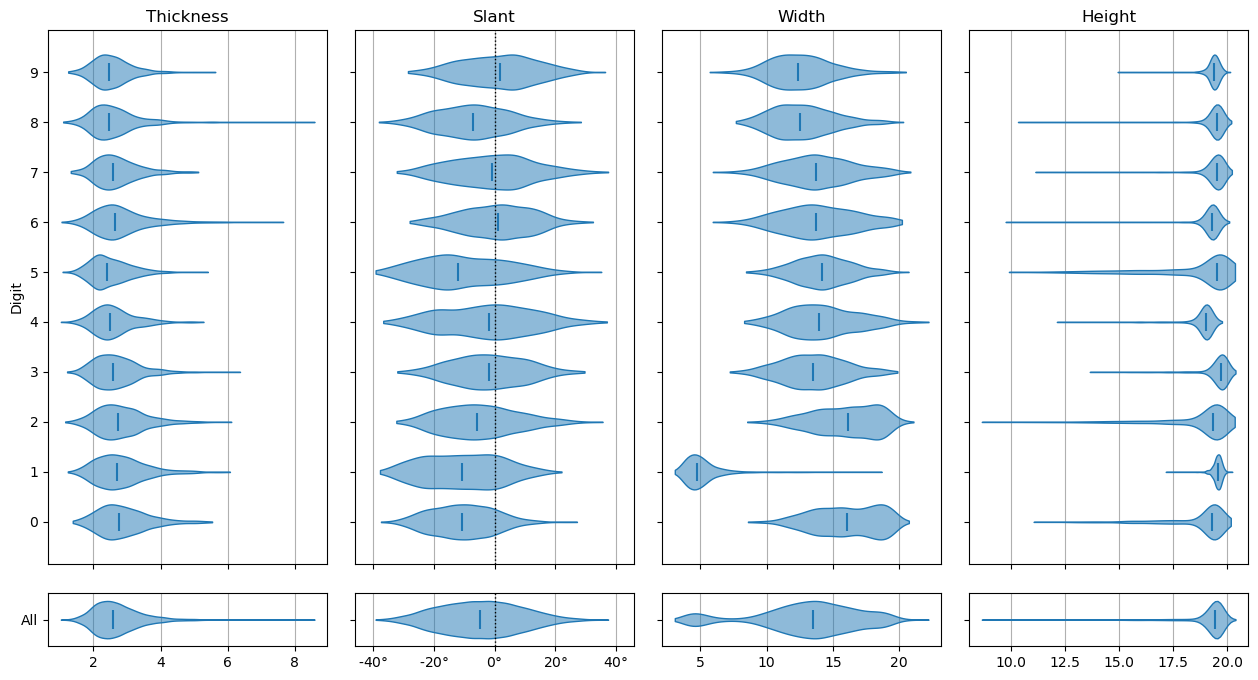

In [179]:
test_morpho['digit'] = y_test
test_morpho['slant_deg'] = np.rad2deg(np.arctan(-test_morpho['slant']))


cols = ['thickness', 'slant_deg', 'width', 'height']
labels = ['Thickness', 'Slant', 'Width', 'Height']
fig, axs = plt.subplots(2, len(cols), sharex='col', sharey='row', figsize=(12, 8),
                            gridspec_kw=dict(height_ratios=[10, 1], hspace=.1, wspace=.1, left=0,
                                             right=1))

def format_violinplot(parts):
    for pc in parts['bodies']:
        pc.set_facecolor('#1f77b480')
        pc.set_edgecolor('C0')
        pc.set_alpha(None)

for c, col in enumerate(cols):
    ax = axs[0, c]
    parts = ax.violinplot([test_morpho.loc[test_morpho['digit'] == d, col] for d in range(10)],
                              positions=np.arange(10), vert=False, widths=.7,
                              showextrema=False, showmedians=True)
    format_violinplot(parts)
    format_violinplot(axs[1, c].violinplot(test_morpho[col], vert=False, widths=.7,
                                               showextrema=False, showmedians=True))
    ax.set_title(labels[c])
    ax.set_axisbelow(True)
    ax.grid(axis='x')
    axs[1, c].set_axisbelow(True)
    axs[1, c].grid(axis='x')

axs[0, 0].yaxis.set_major_locator(ticker.MultipleLocator(1))
axs[0, 0].set_ylabel("Digit")

axs[1, 0].set_yticks([1])
axs[1, 0].set_yticklabels(["All"])
axs[1, 0].set_ylim(.5, 1.5)
for ax in axs[:, 1]:
    ax.axvline(0., lw=1., ls=':', c='k')

axs[1, 1].set_xlim(-46, 46)
axs[1, 1].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}$\degree$"))
plt.show()

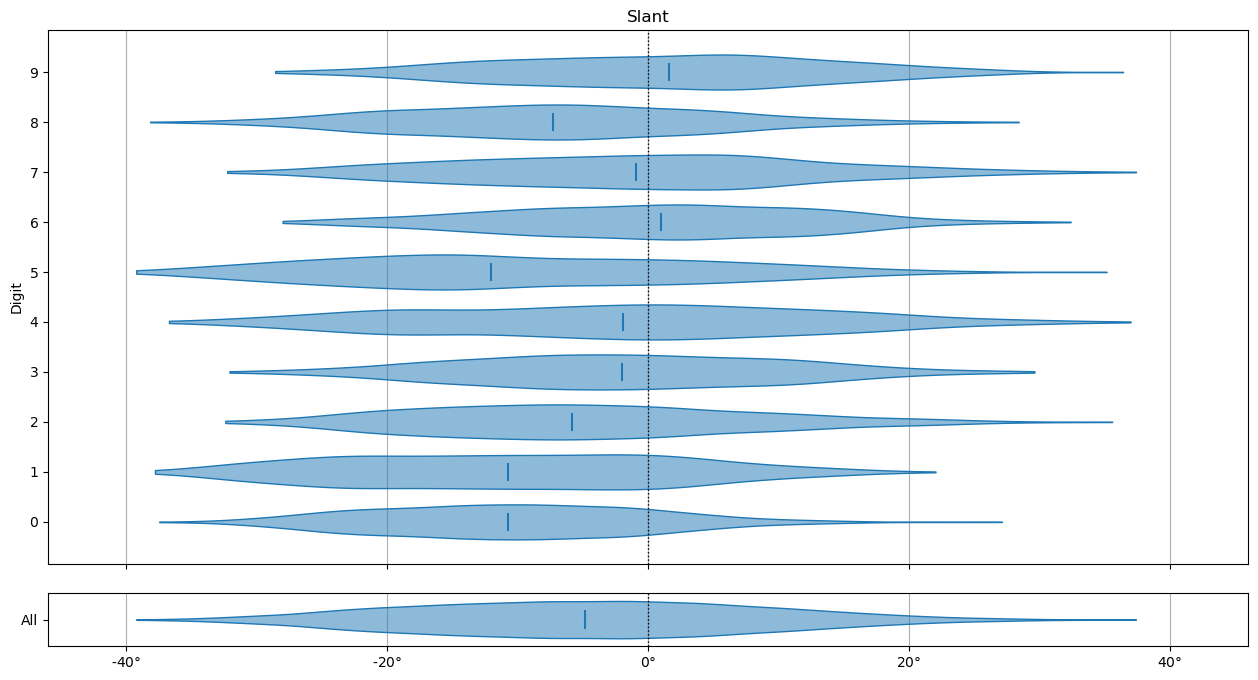

In [180]:
test_morpho['digit'] = y_test
test_morpho['slant_deg'] = np.rad2deg(np.arctan(-test_morpho['slant']))


cols = ['slant_deg']
labels = ['Slant']
fig, axs = plt.subplots(2, len(cols), sharex='col', sharey='row', figsize=(12, 8),
                            gridspec_kw=dict(height_ratios=[10, 1], hspace=.1, wspace=.1, left=0,
                                             right=1))

def format_violinplot(parts):
    for pc in parts['bodies']:
        pc.set_facecolor('#1f77b480')
        pc.set_edgecolor('C0')
        pc.set_alpha(None)

for c, col in enumerate(cols):
    ax = axs[0]
    parts = ax.violinplot([test_morpho.loc[test_morpho['digit'] == d, col] for d in range(10)],
                              positions=np.arange(10), vert=False, widths=.7,
                              showextrema=False, showmedians=True)
    format_violinplot(parts)
    format_violinplot(axs[1].violinplot(test_morpho[col], vert=False, widths=.7,
                                               showextrema=False, showmedians=True))
    ax.set_title(labels[c])
    ax.set_axisbelow(True)
    ax.grid(axis='x')
    axs[1].set_axisbelow(True)
    axs[1].grid(axis='x')

axs[0].yaxis.set_major_locator(ticker.MultipleLocator(1))
axs[0].set_ylabel("Digit")

axs[1].set_yticks([1])
axs[1].set_yticklabels(["All"])
axs[1].set_ylim(.5, 1.5)
for ax in axs[:]:
    ax.axvline(0., lw=1., ls=':', c='k')

axs[1].set_xlim(-46, 46)
axs[1].xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}$\degree$"))
plt.show()

### Convert the dataset from a vector form to a categorical distribution

In [181]:
num_classes = np.max(y_train) + 1
train_y = tf.keras.utils.to_categorical(y_train, num_classes)
test_y = tf.keras.utils.to_categorical(y_test, num_classes)

### Linear Regression Model

#### Define useful callbacks

In [182]:
# Callback to stop training if, after 20 epochs, the MAE is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10)

In [183]:
# Callback to save the weights of the best model
checkpoint_filepath_linear = './checkpoints/linear/'
model_checkpoint_callback_linear = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_linear,
    save_weights_only=True,
    monitor='val_mae',
    mode='max',
    save_best_only=True)

In [184]:
# Callback to save logs and metrics for TensorBoard
log_dir_linear = "logs/fit/linear/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_linear = tf.keras.callbacks.TensorBoard(log_dir=log_dir_linear)

In [185]:
# Callback to reduce LR if we find a plateau in validation MAE
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2,
                              patience=5, min_lr=0.00005)

In [186]:
callbacks = [early_stop_callback, tensorboard_callback_linear, model_checkpoint_callback_linear, reduce_lr]

#### Define and compile the model

Para la regresion lineal se probaron distintas cantidades de capas de MLP, con distintas activaciones e inicializadores, y distintos niveles de dropout. Luego de un análisis preeliminar de la performance de los mismos respecto al MAE, se prosiguió con el siguiente modelo:

In [187]:
linear_model = tf.keras.Sequential()
linear_model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
linear_model.add(tf.keras.layers.Dense(512, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
linear_model.add(tf.keras.layers.Dropout(0.10))
linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
linear_model.add(tf.keras.layers.Dropout(0.05))
linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
linear_model.add(tf.keras.layers.Dense(1, activation="linear"))
linear_model.summary()

Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_79 (Flatten)        (None, 784)               0         
                                                                 
 dense_316 (Dense)           (None, 512)               401920    
                                                                 
 dropout_158 (Dropout)       (None, 512)               0         
                                                                 
 dense_317 (Dense)           (None, 64)                32832     
                                                                 
 dropout_159 (Dropout)       (None, 64)                0         
                                                                 
 dense_318 (Dense)           (None, 64)                4160      
                                                                 
 dense_319 (Dense)           (None, 1)               

In [188]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.999)
metrics = ["mae"]
linear_model.compile(loss = 'mae', optimizer=optimizer, metrics=metrics)

#### Fit the model to the train data and validate it with the test data

In [189]:
linear_history = linear_model.fit(x_train, train_morpho["slant"].values, validation_data=(x_test, test_morpho["slant"].values), batch_size = 256, epochs=200, callbacks=callbacks)

Epoch 1/200
235/235 [==============================] - 1s 3ms/step - loss: 0.1636 - mae: 0.1636 - val_loss: 0.0255 - val_mae: 0.0255 - lr: 0.0010
Epoch 2/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0339 - mae: 0.0339 - val_loss: 0.0171 - val_mae: 0.0171 - lr: 0.0010
Epoch 3/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0220 - mae: 0.0220 - val_loss: 0.0067 - val_mae: 0.0067 - lr: 0.0010
Epoch 4/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0165 - mae: 0.0165 - val_loss: 0.0114 - val_mae: 0.0114 - lr: 0.0010
Epoch 5/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0144 - mae: 0.0144 - val_loss: 0.0062 - val_mae: 0.0062 - lr: 0.0010
Epoch 6/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0128 - mae: 0.0128 - val_loss: 0.0068 - val_mae: 0.0068 - lr: 0.0010
Epoch 7/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0120 - mae: 0.0120 - val_loss: 0.0064 - val_mae

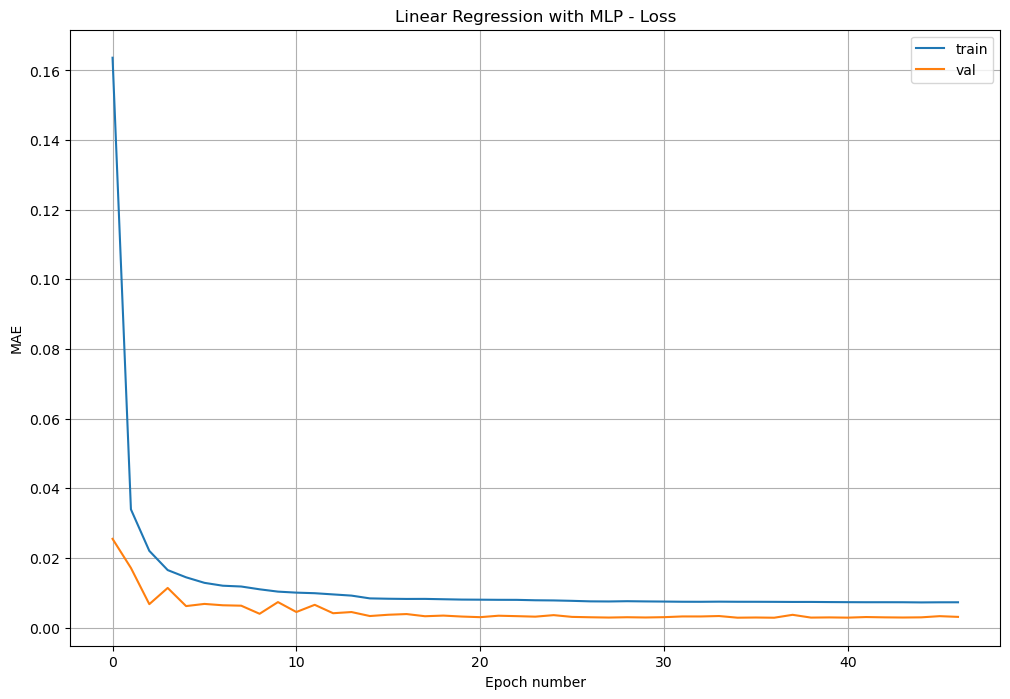

In [190]:
plt.figure(figsize=(12,8))
plt.plot(linear_history.history["loss"], label="train")
plt.plot(linear_history.history["val_loss"], label="val")
plt.title("Linear Regression with MLP - Loss")
plt.xlabel("Epoch number")
plt.ylabel("MAE")
plt.legend()
plt.grid()
plt.show()

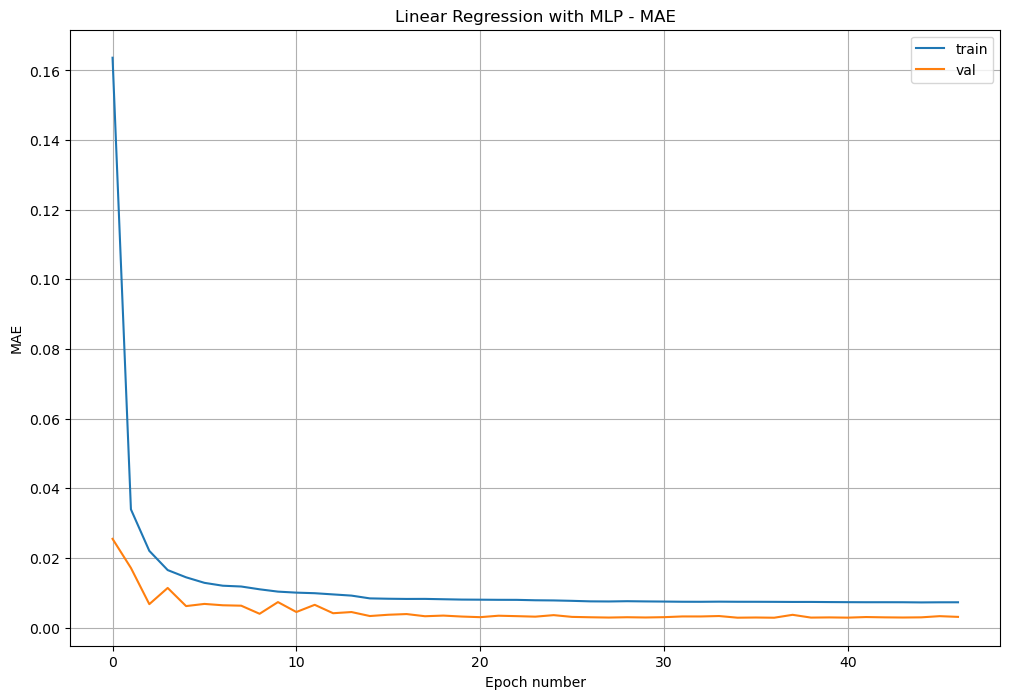

In [191]:
plt.figure(figsize=(12,8))
plt.plot(linear_history.history["mae"], label="train") # Como usamos de loss el MAE, dan lo mismo
plt.plot(linear_history.history["val_mae"], label="val")
plt.title("Linear Regression with MLP - MAE")
plt.xlabel("Epoch number")
plt.ylabel("MAE")
plt.legend()
plt.grid()
plt.show()

### MAE and iterations vs hyperparameters:

Para el modelo elegído, graficamos su MAE y la cantidad de iteraciones de entrenamiento requeridas variando algunos hiperparametros

#### Define useful functions

In [192]:
# Callback to stop training if, after 10 epochs, the accuracy is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=5)

In [193]:
# Callback to save logs and metrics for TensorBoard
log_dir_linear = "logs/fit/linear/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_linear = tf.keras.callbacks.TensorBoard(log_dir=log_dir_linear)

In [194]:
# Callback to reduce LR if we find a plateau in validation accuracy
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2,
                              patience=3, min_lr=0.00005)

In [195]:
callbacks = [early_stop_callback, tensorboard_callback_linear, reduce_lr]

#### Vs Learning Rate

In [196]:
linear_model = tf.keras.Sequential()
linear_model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
linear_model.add(tf.keras.layers.Dense(512, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
linear_model.add(tf.keras.layers.Dropout(0.10))
linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
linear_model.add(tf.keras.layers.Dropout(0.05))
linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
linear_model.add(tf.keras.layers.Dense(1, activation="linear"))
linear_model.summary()

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_80 (Flatten)        (None, 784)               0         
                                                                 
 dense_320 (Dense)           (None, 512)               401920    
                                                                 
 dropout_160 (Dropout)       (None, 512)               0         
                                                                 
 dense_321 (Dense)           (None, 64)                32832     
                                                                 
 dropout_161 (Dropout)       (None, 64)                0         
                                                                 
 dense_322 (Dense)           (None, 64)                4160      
                                                                 
 dense_323 (Dense)           (None, 1)               

In [197]:
train_mae = []
val_mae = []
num_of_steps = []
learning_rate = []

for i in range(10):
    # Model initialization
    linear_model = tf.keras.Sequential()
    linear_model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
    linear_model.add(tf.keras.layers.Dense(512, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
    linear_model.add(tf.keras.layers.Dropout(0.10))
    linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
    linear_model.add(tf.keras.layers.Dropout(0.05))
    linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
    linear_model.add(tf.keras.layers.Dense(1, activation="linear"))
    linear_model.summary()

    # Model compilation and training
    optimizer = tf.keras.optimizers.Adam(learning_rate=i * 0.001 + 0.001, beta_1=0.95, beta_2=0.999)
    learning_rate.append(i * 0.001 + 0.001)
    metrics = ["mae"]
    linear_model.compile(loss = 'mae', optimizer=optimizer, metrics=metrics)
    linear_history = linear_model.fit(x_train, train_morpho["slant"].values, validation_data=(x_test, test_morpho["slant"].values), batch_size = 256, epochs=200, callbacks=[early_stop_callback, tensorboard_callback_linear]) # We remove the reduce_lr callback as we are checking variations with LR
    train_mae.append(np.min(linear_history.history["mae"]))
    val_mae.append(np.min(linear_history.history["val_mae"]))
    num_of_steps.append(len(linear_history.history["mae"]) * 256) # Iterations = num of epochs * batch size
 

Model: "sequential_81"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_81 (Flatten)        (None, 784)               0         
                                                                 
 dense_324 (Dense)           (None, 512)               401920    
                                                                 
 dropout_162 (Dropout)       (None, 512)               0         
                                                                 
 dense_325 (Dense)           (None, 64)                32832     
                                                                 
 dropout_163 (Dropout)       (None, 64)                0         
                                                                 
 dense_326 (Dense)           (None, 64)                4160      
                                                                 
 dense_327 (Dense)           (None, 1)               

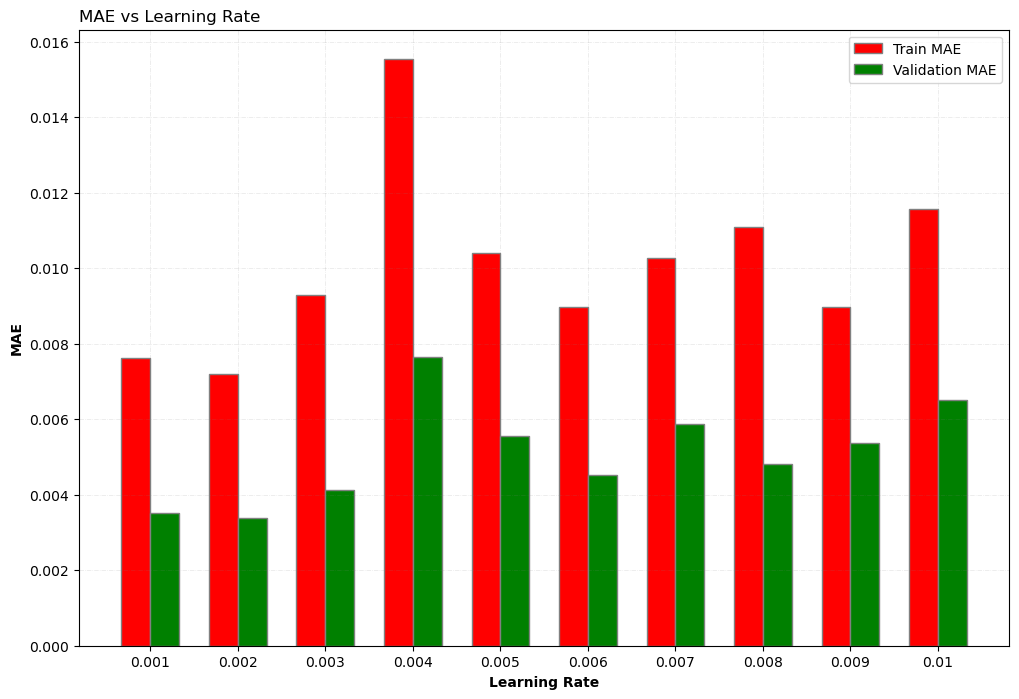

In [198]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(learning_rate))
br2 = [x + barWidth for x in br1]

plt.bar(br1, train_mae, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train MAE')
plt.bar(br2, val_mae, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation MAE')
 
plt.xlabel('Learning Rate', fontweight ='bold', fontsize = 10)
plt.ylabel('MAE', fontweight ='bold', fontsize = 10)
plt.xticks([(r + barWidth/2) for r in range(len(learning_rate))],
        ['0.001', '0.002', '0.003', '0.004', '0.005', '0.006', '0.007', '0.008', '0.009', '0.01'])
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('MAE vs Learning Rate',
             loc ='left', )
plt.legend()
plt.show()

Observamos como, a medida que aumenta el learning rate, aumenta tanto el MAE de entrenamiento como el de validación. Esto es porque un mayor learning rate le otorga mayor velocidad de convergencia, pero menor precisión para obtener el minimo del loss, que genera mayores valores de MAE. Vemos que hay algunas discrepancias, y esto se debe a que como Adam es un algoritmo que no es estrictamente decreciente, con learning rates más altos tenemos varianza en los valores de MAE obtenidos, y como estamos graficando el mínimo existe la posibilidad de que justo un epoch de un learning rate mayor haya tenido mejor MAE. En promedio, utilizar un learning rate menor nos permite llegar de manera más precisa al mínimo.

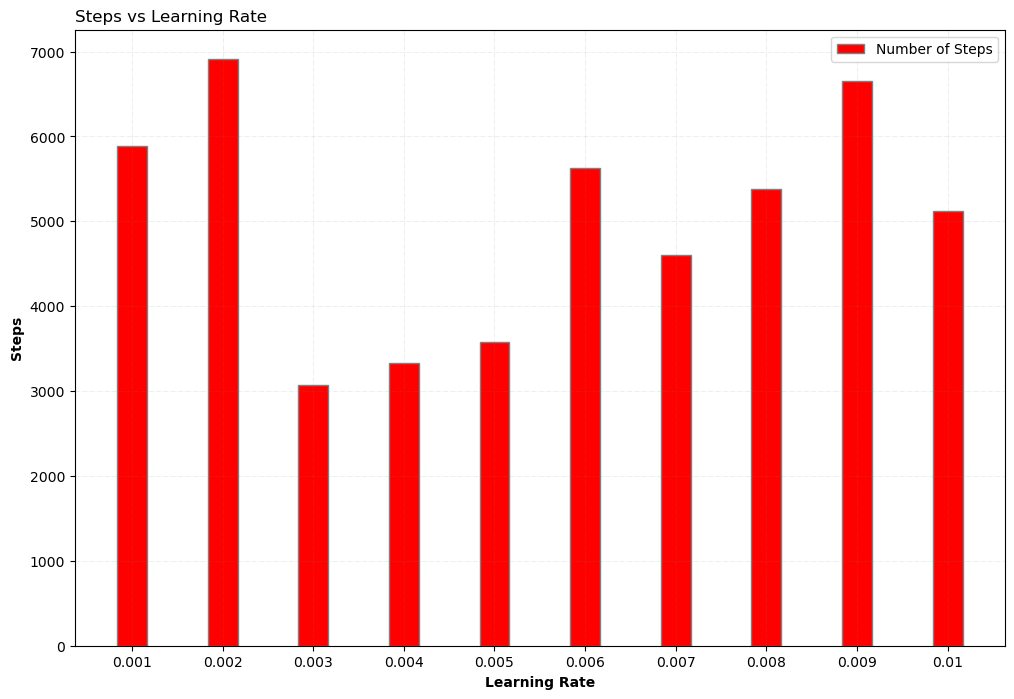

In [199]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(learning_rate))

plt.bar(br1, num_of_steps, color ='r', width = barWidth,
        edgecolor ='grey', label ='Number of Steps')
 
plt.xlabel('Learning Rate', fontweight ='bold', fontsize = 10)
plt.ylabel('Steps', fontweight ='bold', fontsize = 10)
plt.xticks([r  for r in range(len(learning_rate))],
        ['0.001', '0.002', '0.003', '0.004', '0.005', '0.006', '0.007', '0.008', '0.009', '0.01'])
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Steps vs Learning Rate',
             loc ='left', )
plt.legend()
plt.show()

Observamos además no hay una correlación muy fuerte entre learning rate y pasos de entrenamiento requeridos.

#### Vs Batch Size

In [200]:
train_mae = []
val_mae = []
num_of_steps = []
batch_size = []

for i in range(5):
    # Model initialization
    # Model initialization
    linear_model = tf.keras.Sequential()
    linear_model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
    linear_model.add(tf.keras.layers.Dense(512, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
    linear_model.add(tf.keras.layers.Dropout(0.10))
    linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
    linear_model.add(tf.keras.layers.Dropout(0.05))
    linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
    linear_model.add(tf.keras.layers.Dense(1, activation="linear"))
    linear_model.summary()

    # Model compiling and training
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.999)
    curr_batch_size = 32 * 2 ** i
    batch_size.append(curr_batch_size)
    metrics = ["mae"]
    linear_model.compile(loss = 'mae', optimizer=optimizer, metrics=metrics)
    linear_history = linear_model.fit(x_train, train_morpho["slant"].values, validation_data=(x_test, test_morpho["slant"].values), batch_size = curr_batch_size, epochs=200, callbacks=callbacks)
    train_mae.append(np.min(linear_history.history["mae"]))
    val_mae.append(np.min(linear_history.history["val_mae"]))
    num_of_steps.append(len(linear_history.history["mae"]) * curr_batch_size) # Iterations = num of epochs * batch size
 

Model: "sequential_91"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_91 (Flatten)        (None, 784)               0         
                                                                 
 dense_364 (Dense)           (None, 512)               401920    
                                                                 
 dropout_182 (Dropout)       (None, 512)               0         
                                                                 
 dense_365 (Dense)           (None, 64)                32832     
                                                                 
 dropout_183 (Dropout)       (None, 64)                0         
                                                                 
 dense_366 (Dense)           (None, 64)                4160      
                                                                 
 dense_367 (Dense)           (None, 1)               

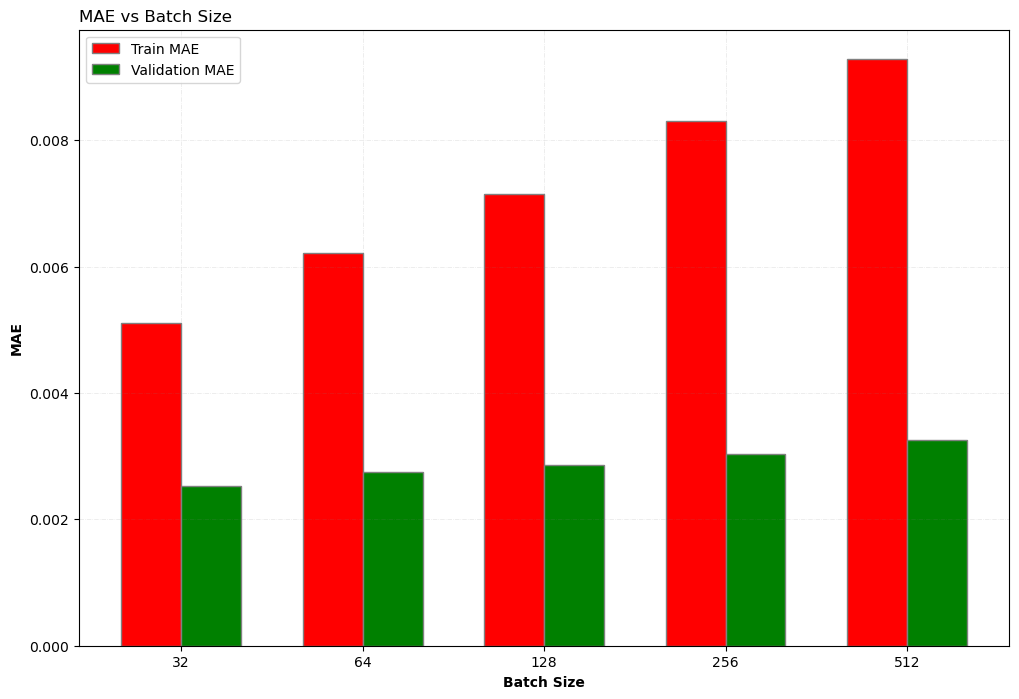

In [201]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(batch_size))
br2 = [x + barWidth for x in br1]

plt.bar(br1, train_mae, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train MAE')
plt.bar(br2, val_mae, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation MAE')
 
plt.xlabel('Batch Size', fontweight ='bold', fontsize = 10)
plt.ylabel('MAE', fontweight ='bold', fontsize = 10)
plt.xticks([(r + barWidth/2) for r in range(len(batch_size))],
        ['32', '64', '128', '256', '512'])
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('MAE vs Batch Size',
             loc ='left', )
plt.legend()
plt.show()

Observamos que a mayor batch size, mayores son los MAE de entrenamiento y validación. Sin embargo, para lograr un compromiso entre velocidad de entrenamiento y performance, elegimos utilizar como batch size 256.

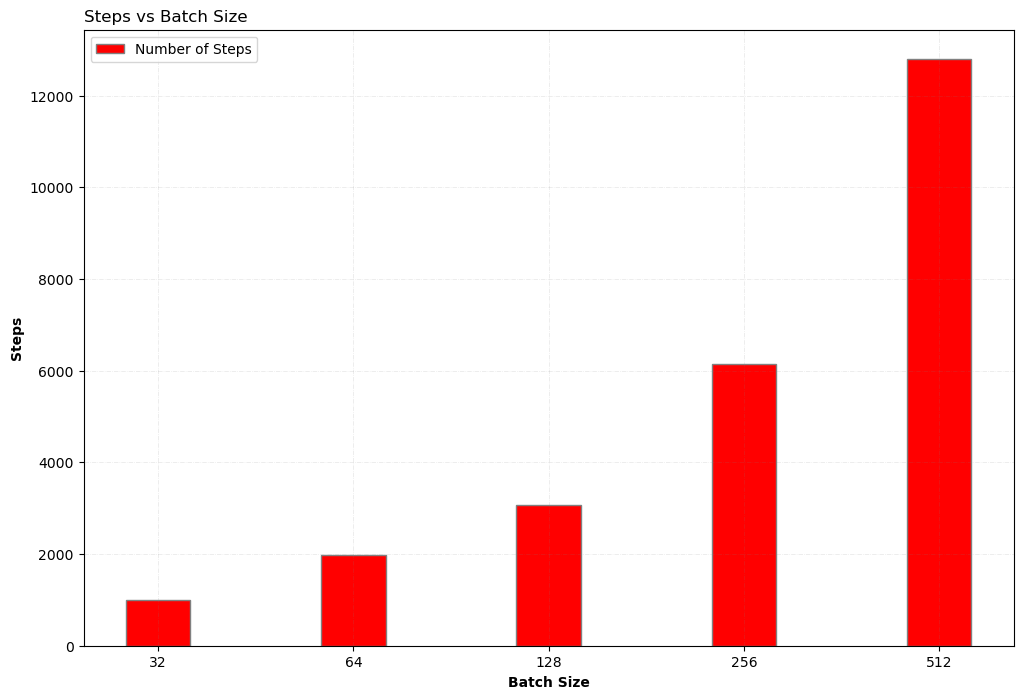

In [202]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(batch_size))

plt.bar(br1, num_of_steps, color ='r', width = barWidth,
        edgecolor ='grey', label ='Number of Steps')
 
plt.xlabel('Batch Size', fontweight ='bold', fontsize = 10)
plt.ylabel('Steps', fontweight ='bold', fontsize = 10)
plt.xticks([r  for r in range(len(batch_size))],
        ['32', '64', '128', '256', '512'])
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Steps vs Batch Size',
             loc ='left', )
plt.legend()
plt.show()

Observamos, como se esperaba, que los steps realizadas aumentan junto con el batch size, ya que en cada iteración se pasan una mayor cantidad de datos por el modelo.

#### Vs Optimizadores

In [203]:
train_mae = []
val_mae = []
num_of_steps = []
optimizers_list = []

for i in range(4):
    # Model initialization
    linear_model = tf.keras.Sequential()
    linear_model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
    linear_model.add(tf.keras.layers.Dense(512, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
    linear_model.add(tf.keras.layers.Dropout(0.10))
    linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
    linear_model.add(tf.keras.layers.Dropout(0.05))
    linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
    linear_model.add(tf.keras.layers.Dense(1, activation="linear"))
    linear_model.summary()

    # Model compiling and training
    if (i == 0):
        optimizer = tf.keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.94, beta_2=0.999)
        optimizers_list.append("nadam")
    elif (i == 1):
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.94, beta_2=0.999)
        optimizers_list.append("adam")
    elif (i == 2):
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
        optimizers_list.append("SGD")
    elif (i == 3):
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        optimizers_list.append("RMSProp")
    metrics = ["mae"]
    linear_model.compile(loss = 'mae', optimizer=optimizer, metrics=metrics)
    linear_history = linear_model.fit(x_train, train_morpho["slant"].values, validation_data=(x_test, test_morpho["slant"].values), batch_size = 256, epochs=200, callbacks=callbacks)
    train_mae.append(np.min(linear_history.history["mae"]))
    val_mae.append(np.min(linear_history.history["val_mae"]))
    num_of_steps.append(len(linear_history.history["mae"]) * 256) # Iterations = num of epochs * batch size
 

Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_96 (Flatten)        (None, 784)               0         
                                                                 
 dense_384 (Dense)           (None, 512)               401920    
                                                                 
 dropout_192 (Dropout)       (None, 512)               0         
                                                                 
 dense_385 (Dense)           (None, 64)                32832     
                                                                 
 dropout_193 (Dropout)       (None, 64)                0         
                                                                 
 dense_386 (Dense)           (None, 64)                4160      
                                                                 
 dense_387 (Dense)           (None, 1)               

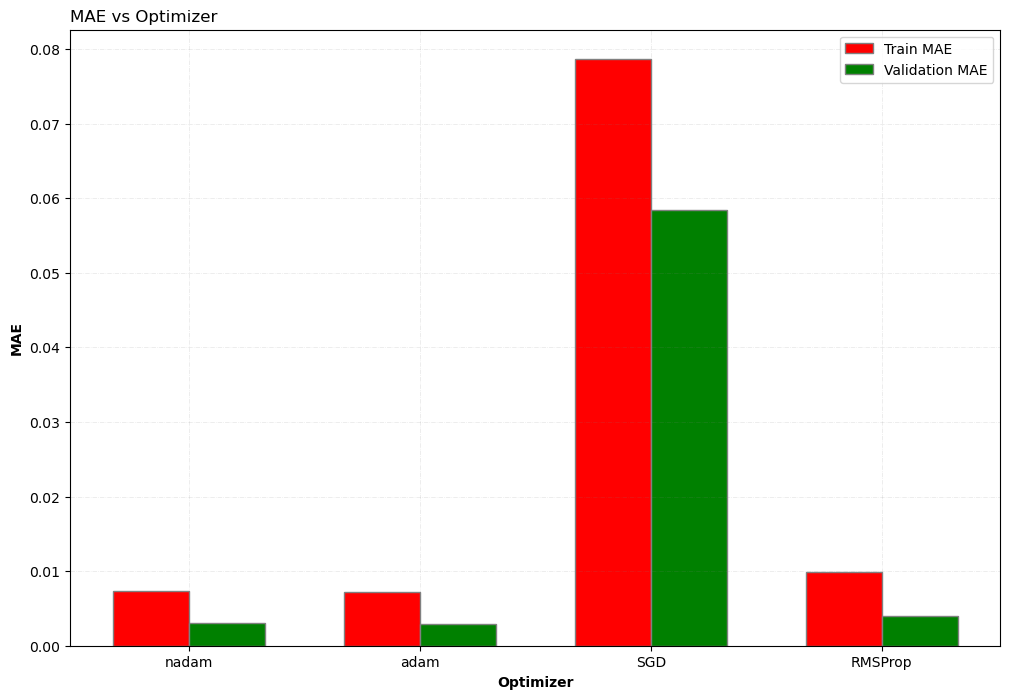

In [204]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(optimizers_list))
br2 = [x + barWidth for x in br1]

plt.bar(br1, train_mae, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train MAE')
plt.bar(br2, val_mae, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation MAE')
 
plt.xlabel('Optimizer', fontweight ='bold', fontsize = 10)
plt.ylabel('MAE', fontweight ='bold', fontsize = 10)
plt.xticks([(r + barWidth/2) for r in range(len(optimizers_list))],
        optimizers_list)
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('MAE vs Optimizer',
             loc ='left', )
plt.legend()
plt.show()

Observamos que el de mayor performance tanto en training como en validación es Adam, seguido muy de cerca por Nadam y RMSProp.

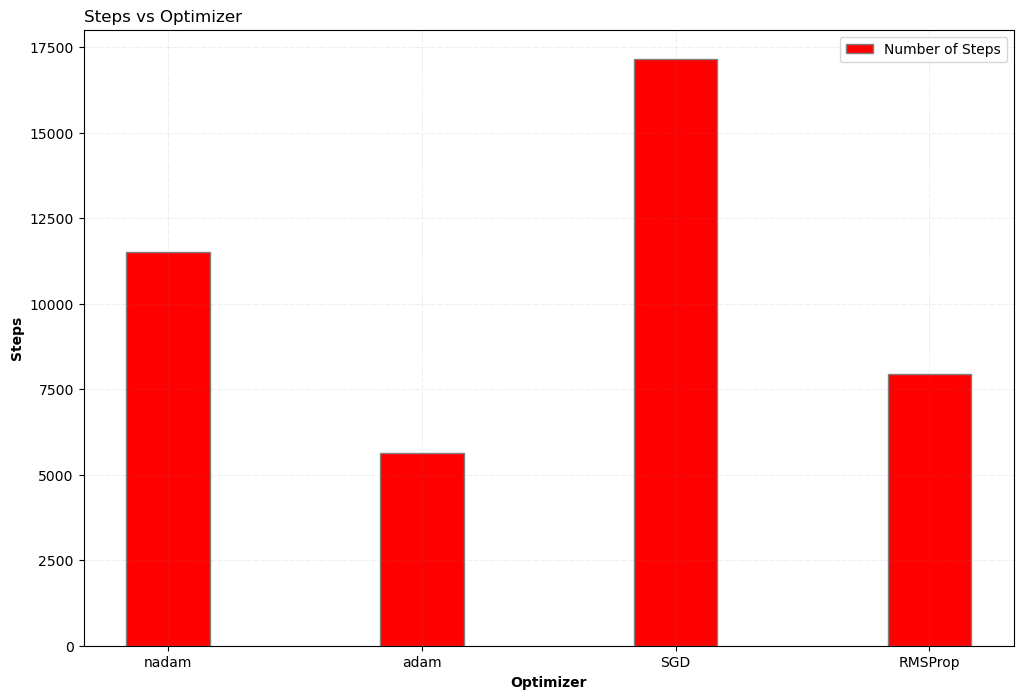

In [205]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(optimizers_list))

plt.bar(br1, num_of_steps, color ='r', width = barWidth,
        edgecolor ='grey', label ='Number of Steps')
 
plt.xlabel('Optimizer', fontweight ='bold', fontsize = 10)
plt.ylabel('Steps', fontweight ='bold', fontsize = 10)
plt.xticks([r  for r in range(len(optimizers_list))],
        optimizers_list)
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Steps vs Optimizer',
             loc ='left', )
plt.legend()
plt.show()

Observamos además que el optimizador Adam también es el que menor pasos de entrenamiento requiere, por eso su elección.

#### Vs Activaciones

In [206]:
train_mae = []
val_mae = []
num_of_steps = []
acivation_list = []

for i in range(6):
    
    # Model initialization
    linear_model = tf.keras.Sequential()
    linear_model.add(tf.keras.layers.Flatten(input_shape=(28,28)))

    if (i == 0):
        linear_model.add(tf.keras.layers.Dense(512, activation="elu", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.10))
        linear_model.add(tf.keras.layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.05))
        linear_model.add(tf.keras.layers.Dense(64, activation="elu", kernel_initializer=tf.keras.initializers.GlorotNormal))
        acivation_list.append("elu")
    elif (i == 1):
        linear_model.add(tf.keras.layers.Dense(512, activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.10))
        linear_model.add(tf.keras.layers.Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.05))
        linear_model.add(tf.keras.layers.Dense(64, activation="relu", kernel_initializer=tf.keras.initializers.GlorotNormal))
        acivation_list.append("relu")
    elif (i == 2):
        linear_model.add(tf.keras.layers.Dense(512, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.10))
        linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.05))
        linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
        acivation_list.append("sigmoid")
    elif (i == 3):
        linear_model.add(tf.keras.layers.Dense(512, activation="softmax", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.10))
        linear_model.add(tf.keras.layers.Dense(64, activation="softmax", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.05))
        linear_model.add(tf.keras.layers.Dense(64, activation="softmax", kernel_initializer=tf.keras.initializers.GlorotNormal))
        acivation_list.append("softmax")
    elif (i == 4):
        linear_model.add(tf.keras.layers.Dense(512, activation="softplus", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.10))
        linear_model.add(tf.keras.layers.Dense(64, activation="softplus", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.05))
        linear_model.add(tf.keras.layers.Dense(64, activation="softplus", kernel_initializer=tf.keras.initializers.GlorotNormal))
        acivation_list.append("softplus")
    elif (i == 5):
        linear_model.add(tf.keras.layers.Dense(512, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.10))
        linear_model.add(tf.keras.layers.Dense(64, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.05))
        linear_model.add(tf.keras.layers.Dense(64, activation="tanh", kernel_initializer=tf.keras.initializers.GlorotNormal))
        acivation_list.append("tanh")
    
    linear_model.add(tf.keras.layers.Dense(1, activation="linear"))
    linear_model.summary()

    # Model compiling and training

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.999)
    metrics = ["mae"]
    linear_model.compile(loss = 'mae', optimizer=optimizer, metrics=metrics)
    linear_history = linear_model.fit(x_train, train_morpho["slant"].values, validation_data=(x_test, test_morpho["slant"].values), batch_size = 256, epochs=200, callbacks=callbacks)
    train_mae.append(np.min(linear_history.history["mae"]))
    val_mae.append(np.min(linear_history.history["val_mae"]))
    num_of_steps.append(len(linear_history.history["mae"]) * 256) # Iterations = num of epochs * batch size

Model: "sequential_100"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_100 (Flatten)       (None, 784)               0         
                                                                 
 dense_400 (Dense)           (None, 512)               401920    
                                                                 
 dropout_200 (Dropout)       (None, 512)               0         
                                                                 
 dense_401 (Dense)           (None, 64)                32832     
                                                                 
 dropout_201 (Dropout)       (None, 64)                0         
                                                                 
 dense_402 (Dense)           (None, 64)                4160      
                                                                 
 dense_403 (Dense)           (None, 1)              

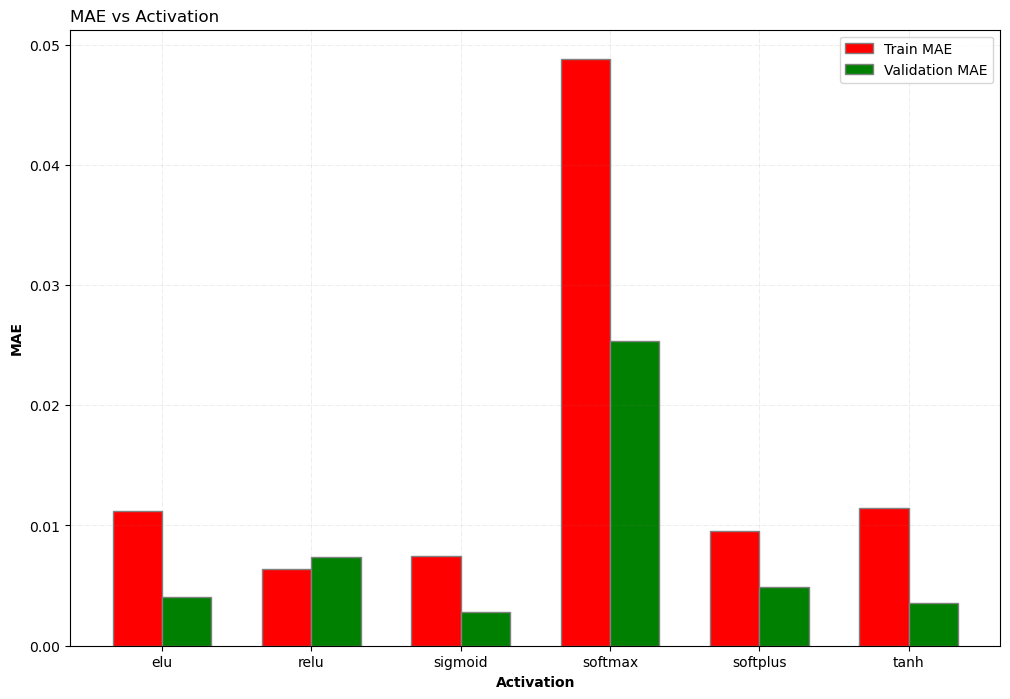

In [207]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(acivation_list))
br2 = [x + barWidth for x in br1]

plt.bar(br1, train_mae, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train MAE')
plt.bar(br2, val_mae, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation MAE')
 
plt.xlabel('Activation', fontweight ='bold', fontsize = 10)
plt.ylabel('MAE', fontweight ='bold', fontsize = 10)
plt.xticks([(r + barWidth/2) for r in range(len(acivation_list))],
        acivation_list)
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('MAE vs Activation',
             loc ='left', )
plt.legend()
plt.show()

Observamos que el mejor activador para las capas es la sigmoide, a pesar de que el activador relu tiene mejor performance con el dataset de entrenamiento.

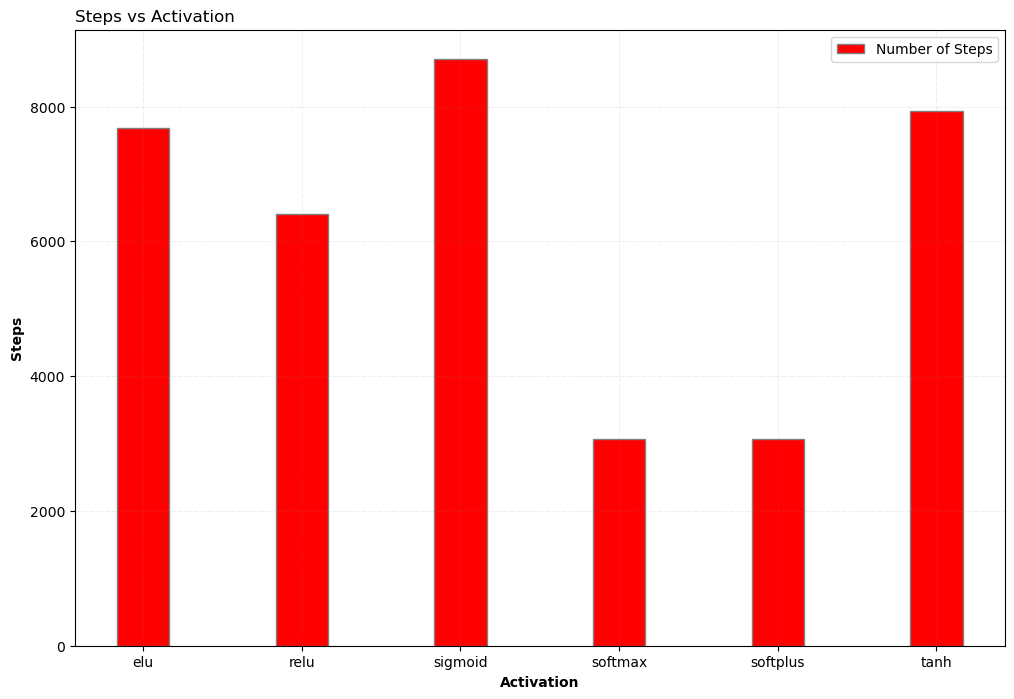

In [208]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(acivation_list))

plt.bar(br1, num_of_steps, color ='r', width = barWidth,
        edgecolor ='grey', label ='Number of Steps')
 
plt.xlabel('Activation', fontweight ='bold', fontsize = 10)
plt.ylabel('Steps', fontweight ='bold', fontsize = 10)
plt.xticks([r  for r in range(len(acivation_list))],
        acivation_list)
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Steps vs Activation',
             loc ='left', )
plt.legend()
plt.show()

Sin embargo, el activador sigmoide requiere la mayor cantidad de pasos de entrenamiento.

#### Vs Dropout Rate

In [209]:
train_mae = []
val_mae = []
num_of_steps = []
dropout_list = []

for i in range(5):
    
    # Model initialization
    linear_model = tf.keras.Sequential()
    linear_model.add(tf.keras.layers.Flatten(input_shape=(28,28)))

    if (i == 0):
        linear_model.add(tf.keras.layers.Dense(512, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.0))
        linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.0))
        linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
        dropout_list.append("No dropout")
    elif (i == 1):
        linear_model.add(tf.keras.layers.Dense(512, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.05))
        linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.05))
        linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
        dropout_list.append("5% dropout")
    elif (i == 2):
        linear_model.add(tf.keras.layers.Dense(512, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.10))
        linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.10))
        linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
        dropout_list.append("10% dropout")
    elif (i == 3):
        linear_model.add(tf.keras.layers.Dense(512, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.25))
        linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.25))
        linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
        dropout_list.append("20% dropout")
    elif (i == 4):
        linear_model.add(tf.keras.layers.Dense(512, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.35))
        linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
        linear_model.add(tf.keras.layers.Dropout(0.35))
        linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
        dropout_list.append("35% dropout")
    
    linear_model.add(tf.keras.layers.Dense(1, activation="linear"))
    linear_model.summary()

    # Model compiling and training

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.999)
    metrics = ["mae"]
    linear_model.compile(loss = 'mae', optimizer=optimizer, metrics=metrics)
    linear_history = linear_model.fit(x_train, train_morpho["slant"].values, validation_data=(x_test, test_morpho["slant"].values), batch_size = 256, epochs=200, callbacks=callbacks)
    train_mae.append(np.min(linear_history.history["mae"]))
    val_mae.append(np.min(linear_history.history["val_mae"]))
    num_of_steps.append(len(linear_history.history["mae"]) * 256) # Iterations = num of epochs * batch size
 

Model: "sequential_106"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_106 (Flatten)       (None, 784)               0         
                                                                 
 dense_424 (Dense)           (None, 512)               401920    
                                                                 
 dropout_212 (Dropout)       (None, 512)               0         
                                                                 
 dense_425 (Dense)           (None, 64)                32832     
                                                                 
 dropout_213 (Dropout)       (None, 64)                0         
                                                                 
 dense_426 (Dense)           (None, 64)                4160      
                                                                 
 dense_427 (Dense)           (None, 1)              

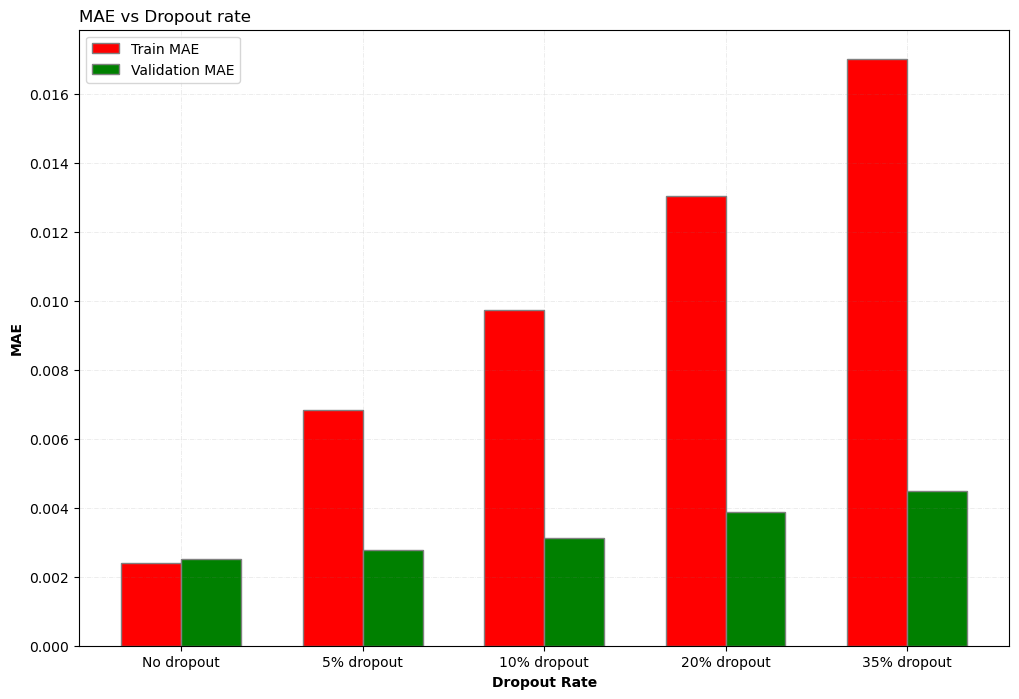

In [210]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(dropout_list))
br2 = [x + barWidth for x in br1]

plt.bar(br1, train_mae, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train MAE')
plt.bar(br2, val_mae, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation MAE')
 
plt.xlabel('Dropout Rate', fontweight ='bold', fontsize = 10)
plt.ylabel('MAE', fontweight ='bold', fontsize = 10)
plt.xticks([(r + barWidth/2) for r in range(len(dropout_list))],
        dropout_list)
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('MAE vs Dropout rate',
             loc ='left', )
plt.legend()
plt.show()

Vemos como, al aumentar el dropout, disminuye la accuracy de training. Esto es lo esperado, ya que el dropout se utiliza para intentar evitar el overfitting (que traería mayor accuracy de training pero menor de validación). Además, observamos que el mejor performance en validación se obtiene para dropouts bajos.

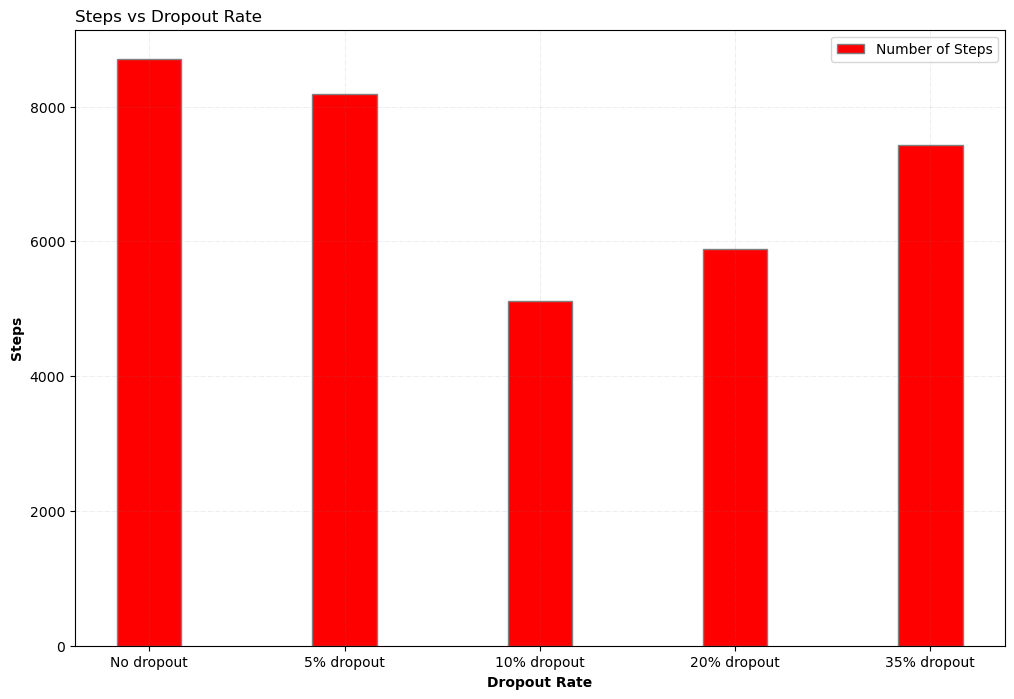

In [211]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(dropout_list))

plt.bar(br1, num_of_steps, color ='r', width = barWidth,
        edgecolor ='grey', label ='Number of Steps')
 
plt.xlabel('Dropout Rate', fontweight ='bold', fontsize = 10)
plt.ylabel('Steps', fontweight ='bold', fontsize = 10)
plt.xticks([r  for r in range(len(dropout_list))],
        dropout_list)
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Steps vs Dropout Rate',
             loc ='left', )
plt.legend()
plt.show()

Observamos además que el menor tiempo de entrenamiento se requiere con un dropout del 10%.

#### Vs Batch Normalization

In [212]:
train_mae = []
val_mae = []
num_of_steps = []
batch_normalization_status = []

for i in range(2):
    # Model initialization
    linear_model = tf.keras.Sequential()
    linear_model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
    if(i == 0):
        linear_model.add(tf.keras.layers.BatchNormalization())
        batch_normalization_status.append("B.N. ON")
    else:
        batch_normalization_status.append("B.N. OFF")
    linear_model.add(tf.keras.layers.Dense(512, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
    linear_model.add(tf.keras.layers.Dropout(0.10))
    linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
    linear_model.add(tf.keras.layers.Dropout(0.05))
    linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal))
    linear_model.add(tf.keras.layers.Dense(1, activation="linear"))
    linear_model.summary()

    # Model compiling and training

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.999)
    metrics = ["mae"]
    linear_model.compile(loss = 'mae', optimizer=optimizer, metrics=metrics)
    linear_history = linear_model.fit(x_train, train_morpho["slant"].values, validation_data=(x_test, test_morpho["slant"].values), batch_size = 256, epochs=200, callbacks=callbacks)
    train_mae.append(np.min(linear_history.history["mae"]))
    val_mae.append(np.min(linear_history.history["val_mae"]))
    num_of_steps.append(len(linear_history.history["mae"]) * 256) # Iterations = num of epochs * batch size
 

Model: "sequential_111"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_111 (Flatten)       (None, 784)               0         
                                                                 
 batch_normalization_52 (Bat  (None, 784)              3136      
 chNormalization)                                                
                                                                 
 dense_444 (Dense)           (None, 512)               401920    
                                                                 
 dropout_222 (Dropout)       (None, 512)               0         
                                                                 
 dense_445 (Dense)           (None, 64)                32832     
                                                                 
 dropout_223 (Dropout)       (None, 64)                0         
                                                    

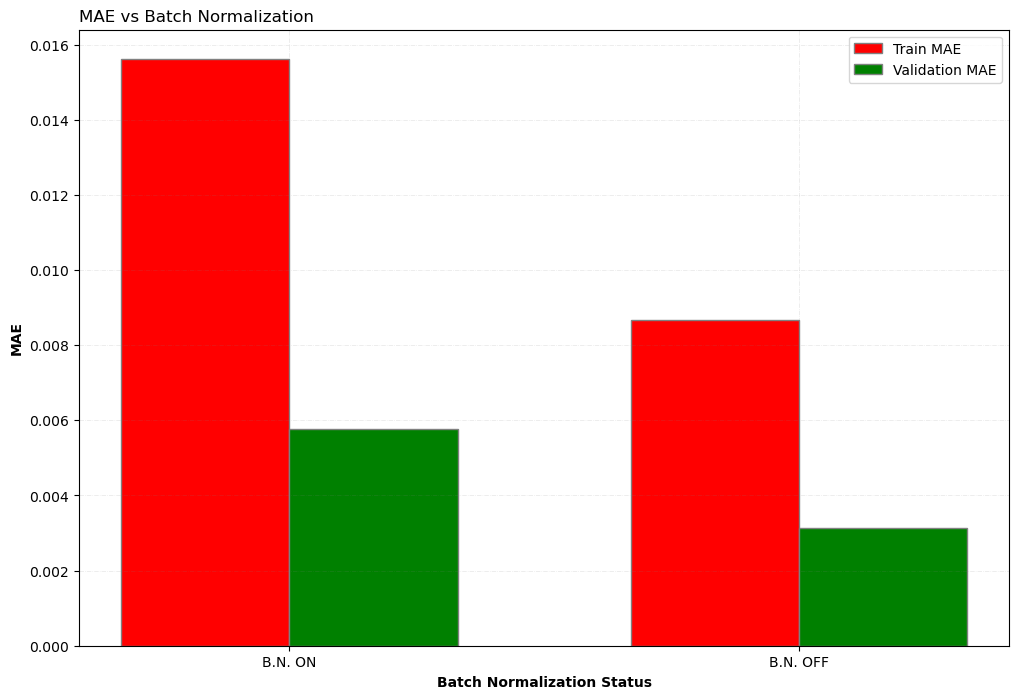

In [213]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(batch_normalization_status))
br2 = [x + barWidth for x in br1]

plt.bar(br1, train_mae, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train MAE')
plt.bar(br2, val_mae, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation MAE')
 
plt.xlabel('Batch Normalization Status', fontweight ='bold', fontsize = 10)
plt.ylabel('MAE', fontweight ='bold', fontsize = 10)
plt.xticks([(r + barWidth/2) for r in range(len(batch_normalization_status))],
        batch_normalization_status)
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('MAE vs Batch Normalization',
             loc ='left', )
plt.legend()
plt.show()

Observamos como utilizar batch normalization con este modelo decrementa considerablemente tanto el MAE de training como el de validación, por lo que lo mantuvimos desactivado.

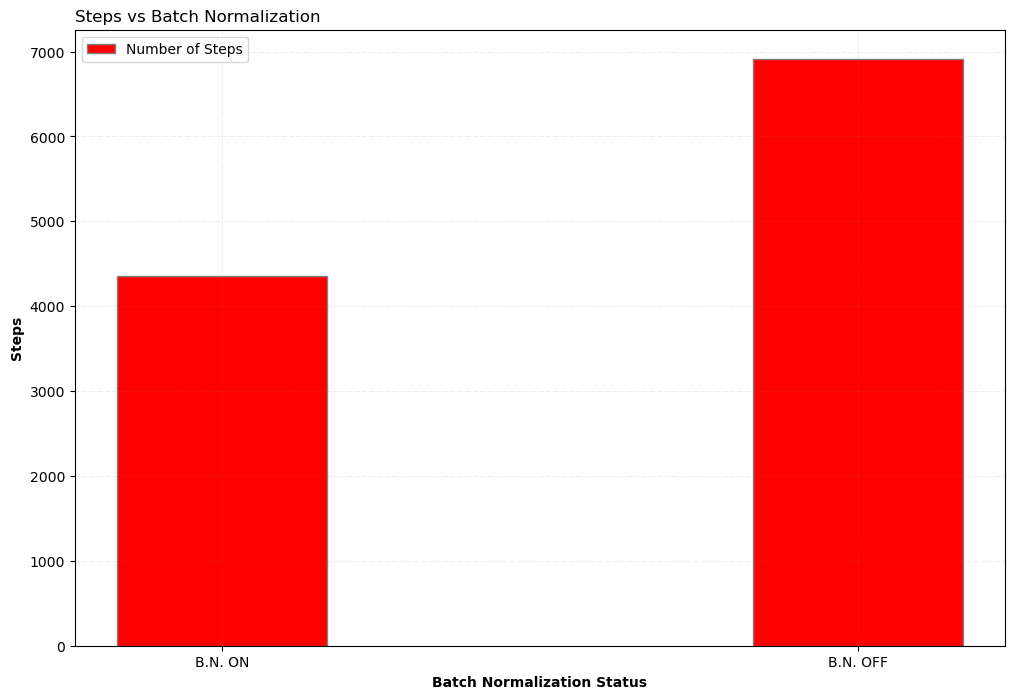

In [214]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(batch_normalization_status))

plt.bar(br1, num_of_steps, color ='r', width = barWidth,
        edgecolor ='grey', label ='Number of Steps')
 
plt.xlabel('Batch Normalization Status', fontweight ='bold', fontsize = 10)
plt.ylabel('Steps', fontweight ='bold', fontsize = 10)
plt.xticks([r  for r in range(len(batch_normalization_status))],
        batch_normalization_status)
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Steps vs Batch Normalization',
             loc ='left', )
plt.legend()
plt.show()

Con batch normalization se realizaron menos steps de entrenamiento ya que su MAE llegó a una plateau mucho antes.

#### Vs Inicializaciones de Pesos

In [215]:
train_mae = []
val_mae = []
num_of_steps = []
weight_initializations = []

for i in range(4):
    
    # Model initialization
    linear_model = tf.keras.Sequential()
    linear_model.add(tf.keras.layers.Flatten(input_shape=(28,28)))

    if (i == 0):
        linear_model.add(tf.keras.layers.Dense(512, activation="sigmoid", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        linear_model.add(tf.keras.layers.Dropout(0.10))
        linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        linear_model.add(tf.keras.layers.Dropout(0.05))
        linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.001)))
        weight_initializations.append("random_normal_dev_1e-3")
    elif (i == 1):
        linear_model.add(tf.keras.layers.Dense(512, activation="sigmoid", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1)))
        linear_model.add(tf.keras.layers.Dropout(0.10))
        linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1)))
        linear_model.add(tf.keras.layers.Dropout(0.05))
        linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1)))
        weight_initializations.append("random_normal_dev_1e-1")
    elif (i == 2):
        linear_model.add(tf.keras.layers.Dense(512, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal()))
        linear_model.add(tf.keras.layers.Dropout(0.10))
        linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal()))
        linear_model.add(tf.keras.layers.Dropout(0.05))
        linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal()))
        weight_initializations.append("glorot_normal")
    elif (i == 3):
        linear_model.add(tf.keras.layers.Dense(512, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform()))
        linear_model.add(tf.keras.layers.Dropout(0.10))
        linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform()))
        linear_model.add(tf.keras.layers.Dropout(0.05))
        linear_model.add(tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform()))
        weight_initializations.append("glorot_uniform")
    
    linear_model.add(tf.keras.layers.Dense(1, activation="linear"))
    linear_model.summary()

    # Model compiling and training

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.999)
    metrics = ["mae"]
    linear_model.compile(loss = 'mae', optimizer=optimizer, metrics=metrics)
    linear_history = linear_model.fit(x_train, train_morpho["slant"].values, validation_data=(x_test, test_morpho["slant"].values), batch_size = 256, epochs=200, callbacks=callbacks)
    train_mae.append(np.min(linear_history.history["mae"]))
    val_mae.append(np.min(linear_history.history["val_mae"]))
    num_of_steps.append(len(linear_history.history["mae"]) * 256) # Iterations = num of epochs * batch size

Model: "sequential_113"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_113 (Flatten)       (None, 784)               0         
                                                                 
 dense_452 (Dense)           (None, 512)               401920    
                                                                 
 dropout_226 (Dropout)       (None, 512)               0         
                                                                 
 dense_453 (Dense)           (None, 64)                32832     
                                                                 
 dropout_227 (Dropout)       (None, 64)                0         
                                                                 
 dense_454 (Dense)           (None, 64)                4160      
                                                                 
 dense_455 (Dense)           (None, 1)              

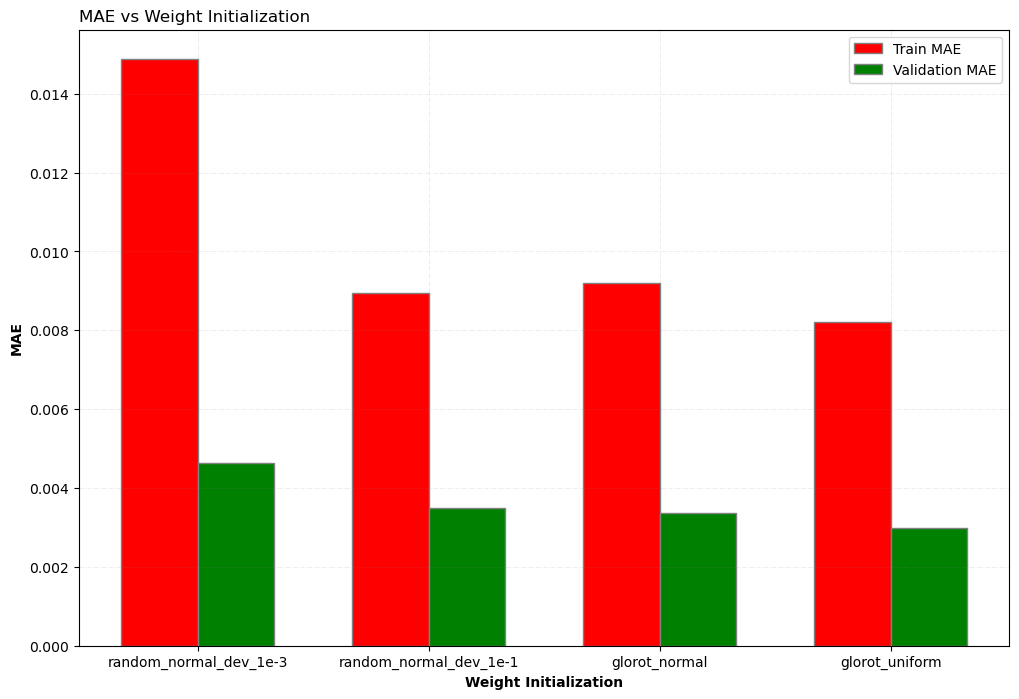

In [216]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(weight_initializations))
br2 = [x + barWidth for x in br1]

plt.bar(br1, train_mae, color ='r', width = barWidth,
        edgecolor ='grey', label ='Train MAE')
plt.bar(br2, val_mae, color ='g', width = barWidth,
        edgecolor ='grey', label ='Validation MAE')
 
plt.xlabel('Weight Initialization', fontweight ='bold', fontsize = 10)
plt.ylabel('MAE', fontweight ='bold', fontsize = 10)
plt.xticks([(r + barWidth/2) for r in range(len(weight_initializations))],
        weight_initializations)
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('MAE vs Weight Initialization',
             loc ='left', )
plt.legend()
plt.show()

Observamos como la mejor performance se obtiene con una inicializacion de pesos GlorotUniform

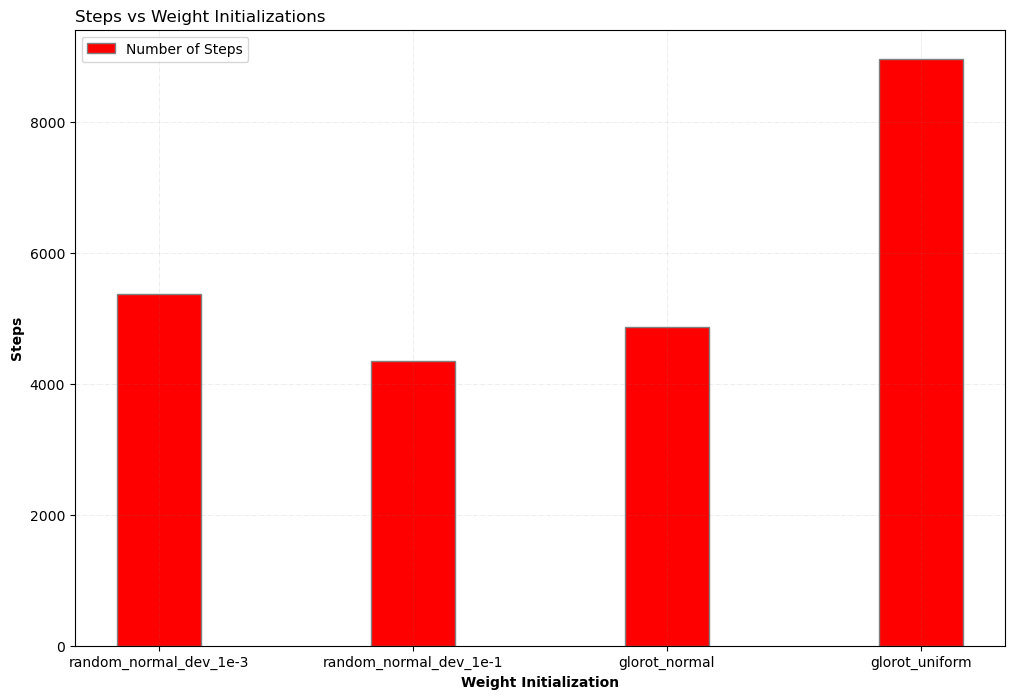

In [217]:
barWidth = 0.33
fig = plt.subplots(figsize =(12, 8))

br1 = np.arange(len(weight_initializations))

plt.bar(br1, num_of_steps, color ='r', width = barWidth,
        edgecolor ='grey', label ='Number of Steps')
 
plt.xlabel('Weight Initialization', fontweight ='bold', fontsize = 10)
plt.ylabel('Steps', fontweight ='bold', fontsize = 10)
plt.xticks([r  for r in range(len(weight_initializations))],
        weight_initializations)
 
plt.grid(color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
plt.title('Steps vs Weight Initializations',
             loc ='left', )
plt.legend()
plt.show()

Observamos que con la inicialización mencionada se requieren más pasos de entrenamiento, pero se llega a un mínimo más pequeño. Sin embargo, una buena relación de compromiso es utilizar pesos GlorotNormal

### Embeddings of size 2 (to use the label)

#### Define useful callbacks

In [218]:
# Callback to stop training if, after 20 epochs, the MAE is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10)

In [219]:
# Callback to save the weights of the best model
checkpoint_filepath_linear_emb = './checkpoints/linear_emb/'
model_checkpoint_callback_linear_emb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_linear_emb,
    save_weights_only=True,
    monitor='val_mae',
    mode='max',
    save_best_only=True)

In [220]:
# Callback to save logs and metrics for TensorBoard
log_dir_linear_emb = "logs/fit/linear_emb/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_linear_emb = tf.keras.callbacks.TensorBoard(log_dir=log_dir_linear_emb)

In [221]:
# Callback to reduce LR if we find a plateau in validation MAE
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2,
                              patience=5, min_lr=0.00005)

In [222]:
callbacks_emb = [early_stop_callback, tensorboard_callback_linear_emb, model_checkpoint_callback_linear_emb, reduce_lr]

#### Define and compile the model

Agregamos al modelo anterior las labels utilizando embeddings de tamaño 2

In [223]:
input_image = tf.keras.layers.Input(shape=(28,28))
input_label = tf.keras.layers.Input(shape=(1,))
flattened_image = tf.keras.layers.Flatten()(input_image)
embedding = tf.keras.layers.Embedding(input_dim=10, output_dim=2, input_length=1)(input_label)
flattened_emb = tf.keras.layers.Flatten()(embedding)
merged = tf.keras.layers.Concatenate(axis=1)([flattened_image, flattened_emb])
dense_1 = tf.keras.layers.Dense(512, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal)(merged)
dropout_1 = tf.keras.layers.Dropout(0.10)(dense_1)
dense_2 = tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal)(dropout_1)
dropout_2 = tf.keras.layers.Dropout(0.05)(dense_2)
dense_3 = tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal)(dropout_2)
dense_out = tf.keras.layers.Dense(1, activation="linear")(dense_3)
linear_model_emb = tf.keras.Model(inputs=[input_image, input_label], outputs=dense_out)
linear_model_emb.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 2)         20          ['input_2[0][0]']                
                                                                                                  
 flatten_117 (Flatten)          (None, 784)          0           ['input_1[0][0]']                
                                                                                              

In [224]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.999)
metrics = ["mae"]
linear_model_emb.compile(loss = 'mae', optimizer=optimizer, metrics=metrics)

#### Fit the model to the train data and validate it with the test data

In [225]:
linear_history_emb = linear_model_emb.fit([x_train, y_train], train_morpho["slant"].values, validation_data=([x_test, y_test], test_morpho["slant"].values), batch_size = 256, epochs=200, callbacks=callbacks)

Epoch 1/200
235/235 [==============================] - 1s 4ms/step - loss: 0.1383 - mae: 0.1383 - val_loss: 0.0187 - val_mae: 0.0187 - lr: 0.0010
Epoch 2/200
235/235 [==============================] - 1s 4ms/step - loss: 0.0241 - mae: 0.0241 - val_loss: 0.0088 - val_mae: 0.0088 - lr: 0.0010
Epoch 3/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0165 - mae: 0.0165 - val_loss: 0.0077 - val_mae: 0.0077 - lr: 0.0010
Epoch 4/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0146 - mae: 0.0146 - val_loss: 0.0050 - val_mae: 0.0050 - lr: 0.0010
Epoch 5/200
235/235 [==============================] - 1s 4ms/step - loss: 0.0131 - mae: 0.0131 - val_loss: 0.0048 - val_mae: 0.0048 - lr: 0.0010
Epoch 6/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0131 - mae: 0.0131 - val_loss: 0.0053 - val_mae: 0.0053 - lr: 0.0010
Epoch 7/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0119 - mae: 0.0119 - val_loss: 0.0057 - val_mae

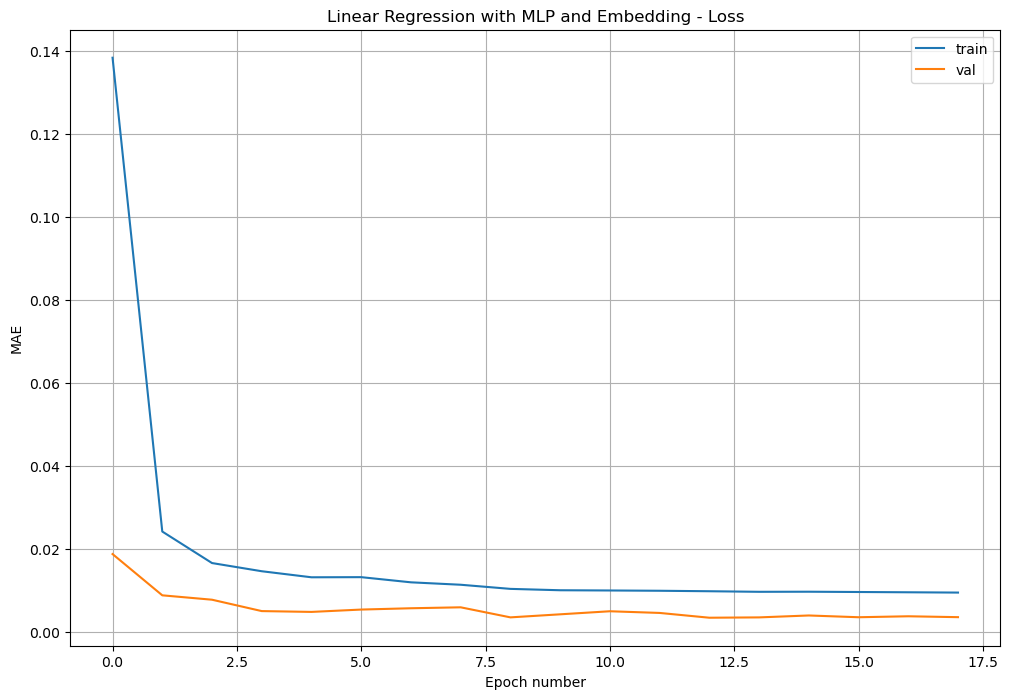

In [226]:
plt.figure(figsize=(12,8))
plt.plot(linear_history_emb.history["loss"], label="train")
plt.plot(linear_history_emb.history["val_loss"], label="val")
plt.title("Linear Regression with MLP and Embedding - Loss")
plt.xlabel("Epoch number")
plt.ylabel("MAE")
plt.legend()
plt.grid()
plt.show()

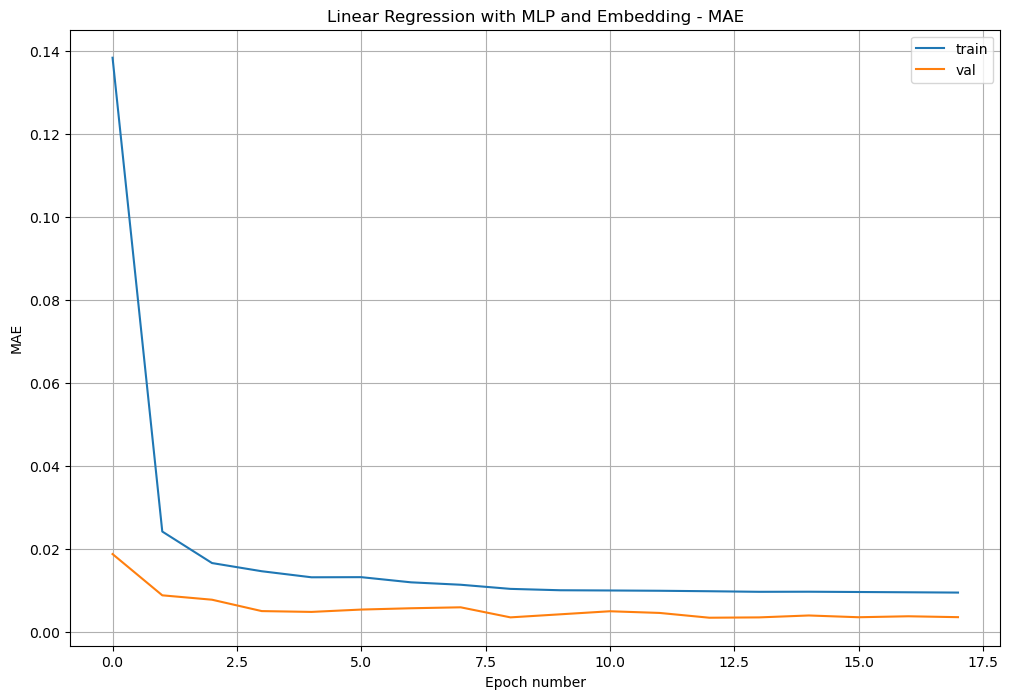

In [227]:
plt.figure(figsize=(12,8))
plt.plot(linear_history_emb.history["mae"], label="train") # Como usamos de loss el MAE, dan lo mismo
plt.plot(linear_history_emb.history["val_mae"], label="val")
plt.title("Linear Regression with MLP and Embedding - MAE")
plt.xlabel("Epoch number")
plt.ylabel("MAE")
plt.legend()
plt.grid()
plt.show()

Observamos que con embeddings logra un rendimiento ligeramente mayor, aunque es muy leve la diferencia.

### Another morphological variable alongside the image

#### Define useful callbacks

In [228]:
# Callback to stop training if, after 20 epochs, the MAE is not improving
early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10)

In [229]:
# Callback to save the weights of the best model
checkpoint_filepath_linear_morph = './checkpoints/linear_morph/'
model_checkpoint_callback_linear_morph = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_linear_morph,
    save_weights_only=True,
    monitor='val_mae',
    mode='max',
    save_best_only=True)

In [230]:
# Callback to save logs and metrics for TensorBoard
log_dir_linear_morph = "logs/fit/linear_morph/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback_linear_morph = tf.keras.callbacks.TensorBoard(log_dir=log_dir_linear_morph)

In [231]:
# Callback to reduce LR if we find a plateau in validation MAE
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.2,
                              patience=5, min_lr=0.00005)

In [232]:
callbacks_morph = [early_stop_callback, tensorboard_callback_linear_morph, model_checkpoint_callback_linear_morph, reduce_lr]

#### Define and compile the model

Agregamos al modelo la utilización de otra variable continua. En este caso, luego de la observación de los scatter plots, elegimos utilizar el width (ya que existe una relación entre este y el slant, porque normalmente para varios digitos entre mayo es el slant, mayor es el width y viceversa)

In [233]:
input_image = tf.keras.layers.Input(shape=(28,28))
input_width = tf.keras.layers.Input(shape=(1,))
flattened_image = tf.keras.layers.Flatten()(input_image)
merged = tf.keras.layers.Concatenate(axis=1)([flattened_image, input_width])
dense_1 = tf.keras.layers.Dense(512, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal)(merged)
dropout_1 = tf.keras.layers.Dropout(0.10)(dense_1)
dense_2 = tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal)(dropout_1)
dropout_2 = tf.keras.layers.Dropout(0.05)(dense_2)
dense_3 = tf.keras.layers.Dense(64, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotNormal)(dropout_2)
dense_out = tf.keras.layers.Dense(1, activation="linear")(dense_3)
linear_model_morph = tf.keras.Model(inputs=[input_image, input_width], outputs=dense_out)
linear_model_morph.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_119 (Flatten)          (None, 784)          0           ['input_3[0][0]']                
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 785)          0           ['flatten_119[0][0]',            
                                                                  'input_4[0][0]']          

In [234]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.95, beta_2=0.999)
metrics = ["mae"]
linear_model_morph.compile(loss = 'mae', optimizer=optimizer, metrics=metrics)

#### Fit the model to the train data and validate it with the test data

In [235]:
linear_history_morph = linear_model_morph.fit([x_train, train_morpho['width'].values], train_morpho["slant"].values, validation_data=([x_test, test_morpho['width'].values], test_morpho["slant"].values), batch_size = 256, epochs=200, callbacks=callbacks)

Epoch 1/200
235/235 [==============================] - 1s 4ms/step - loss: 0.0816 - mae: 0.0816 - val_loss: 0.0151 - val_mae: 0.0151 - lr: 0.0010
Epoch 2/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0200 - mae: 0.0200 - val_loss: 0.0073 - val_mae: 0.0073 - lr: 0.0010
Epoch 3/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0148 - mae: 0.0148 - val_loss: 0.0090 - val_mae: 0.0090 - lr: 0.0010
Epoch 4/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0129 - mae: 0.0129 - val_loss: 0.0049 - val_mae: 0.0049 - lr: 0.0010
Epoch 5/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0121 - mae: 0.0121 - val_loss: 0.0053 - val_mae: 0.0053 - lr: 0.0010
Epoch 6/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0110 - mae: 0.0110 - val_loss: 0.0048 - val_mae: 0.0048 - lr: 0.0010
Epoch 7/200
235/235 [==============================] - 1s 3ms/step - loss: 0.0105 - mae: 0.0105 - val_loss: 0.0069 - val_mae

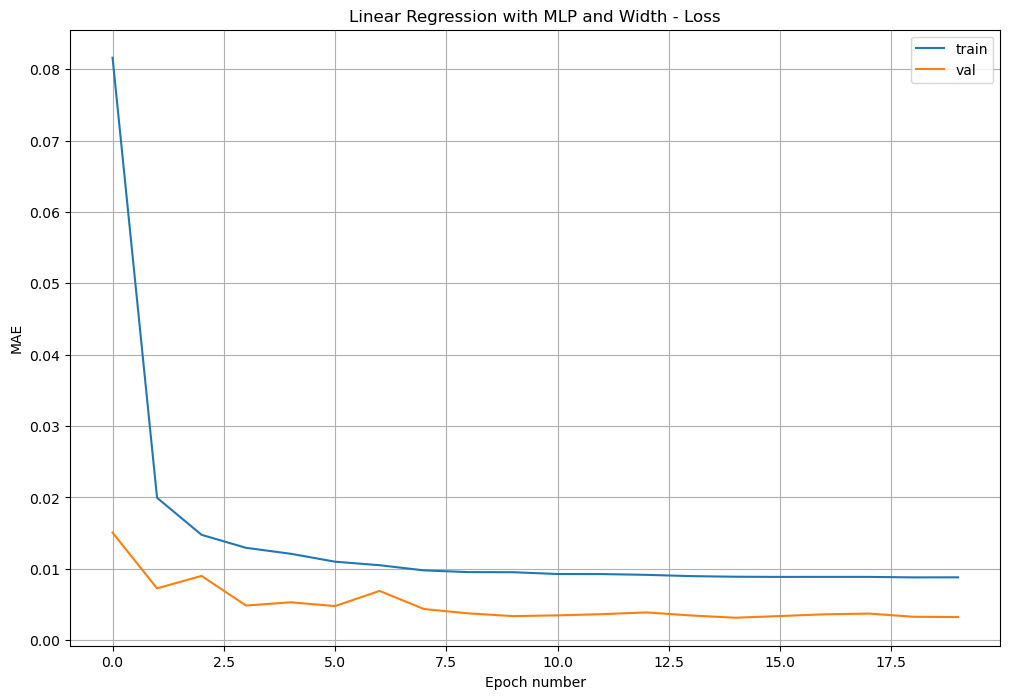

In [236]:
plt.figure(figsize=(12,8))
plt.plot(linear_history_morph.history["loss"], label="train")
plt.plot(linear_history_morph.history["val_loss"], label="val")
plt.title("Linear Regression with MLP and Width - Loss")
plt.xlabel("Epoch number")
plt.ylabel("MAE")
plt.legend()
plt.grid()
plt.show()

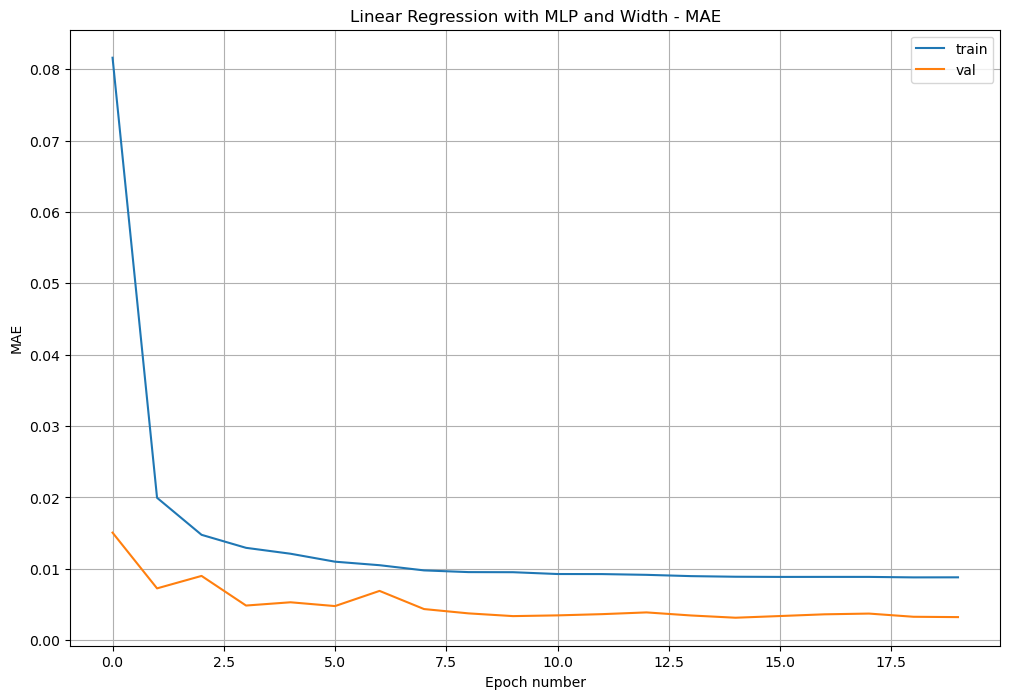

In [237]:
plt.figure(figsize=(12,8))
plt.plot(linear_history_morph.history["mae"], label="train") # Como usamos de loss el MAE, dan lo mismo
plt.plot(linear_history_morph.history["val_mae"], label="val")
plt.title("Linear Regression with MLP and Width - MAE")
plt.xlabel("Epoch number")
plt.ylabel("MAE")
plt.legend()
plt.grid()
plt.show()

Observamos que, al igual que con embeddings del label, agregandole un descriptor morfológico logra un rendimiento ligeramente mayor, aunque es muy leve la diferencia.